In [1]:
import numpy as np
import pandas as pd
import json
import random

n = 50
customer = [i for i in range(1, n + 1)]
node = [0] + customer
arcos = [(i,j) for i in node for j in node if i != j]
f = open('pelanggan.json')
data = json.load(f)
# get customer demand and location data
df = pd.DataFrame(data)
# print(df)
# get distance data
distance = np.loadtxt('distance.txt')
vehicle_capacity = 250
demand = df.demand

In [2]:
default = 0.2
Q = np.zeros((len(node),len(node)))
for i in range(len(node)):
    for j in range(len(node)):
        if(i!=j):
            Q[i][j] = default
DA = np.array([0])
np.savetxt('Q.txt', Q)
np.savetxt('DA.txt',DA)

In [3]:
miu = 0.05
diskon = 0.9
epsilon = 0.05

def bestq(qtable, node, i):
    curr_qtable = qtable[i]
    curr_qtable = np.copy(curr_qtable[node, ])
    max_value = np.max(curr_qtable)
    result = np.where(curr_qtable == max_value)[0]
    if(len(result) == 1):
        return node[result[0]]
    else:
        rnd = random.randint(0,len(result)-1)
        return node[result[rnd]]

def randomq(node):
    result = random.randint(0,len(node)-1)
    return node[result]

def maxq(qtable, node, i):
    curr_qtable = qtable[i]
    curr_qtable = np.copy(curr_qtable[node, ])
    max_value = np.max(curr_qtable)
    return max_value

def minq(qtable, node, i):
    curr_qtable = qtable[i]
    curr_qtable = np.copy(curr_qtable[node, ])
    min_value = np.min(curr_qtable)
    return min_value

def countDistance(route):
    total = 0
    for n in range(len(route)):
        total+=distance[route[n][0]][route[n][1]]
    return total

def updateQ(Q, croute, nodes, total):
    DA = np.loadtxt('DA.txt')
    # r = 1
    #Fungsi untuk Rewrard
    if DA == 0:
        DA = total
        DAnew = total
    else: 
        DAnew = (DA + total)/2
    if(DA>total):
        rn = 1
    else:
        rn = 0
    #End Fungsi untuk Reward
    Qnew = np.copy(Q)
    for k in range(len(croute)):
        route = croute[k]
        node = nodes[k]
        for n in range(len(route) - 1):
            i = route[n][0]
            j = route[n][1]
            if(n == len(route) - 1 ):
                r = rn
            else:
                r = 0
            Qnew[i][j] = Q[i][j] + ( miu * ( r + ( diskon * maxq(Q,node[n],j) ) - Q[i][j] ) )
    np.savetxt('Q.txt', Qnew)  
    np.savetxt('DA.txt', np.array([DAnew]))

def updateQ2(Q, croute, nodes, total):
    DA = np.loadtxt('DA.txt')
    # r = 1
    #Fungsi untuk Rewrard
    if DA == 0:
        DA = total
        
    if(DA>total):
        rn = 1
        DA = total
    else:
        rn = 0
    #End Fungsi untuk Reward
    Qnew = np.copy(Q)
    for k in range(len(croute)):
        route = croute[k]
        node = nodes[k]
        for n in range(len(route) - 1):
            i = route[n][0]
            j = route[n][1]
            if(n == len(route) - 1 ):
                r = rn
            else:
                r = 0
            Qnew[i][j] = Q[i][j] + ( miu * ( r + ( diskon * maxq(Q,node[n],j) ) - Q[i][j] ) )
    np.savetxt('Q.txt', Qnew)  
    np.savetxt('DA.txt', np.array([DA]))

def updateQ3(Q, croute, nodes, total):
    DA = np.loadtxt('DA.txt')
    # r = 1
    #Fungsi untuk Rewrard
    if DA == 0:
        DA = total
        
    if(DA>=total):
        r = 1
        DA = total
    else:
        r = 0
    #End Fungsi untuk Reward
    print(r)
    Qnew = np.copy(Q)
    for k in range(len(croute)):
        route = croute[k]
#         print(route)
        node = nodes[k]
        for n in range(len(route) - 1):
            i = route[n][0]
            j = route[n][1]
            Qnew[i][j] = Q[i][j] + ( miu * ( r + ( diskon * maxq(Q,node[n],j) ) - Q[i][j] ) )
#             print(Q[i][j])
#             print( r + ( diskon * maxq(Q,node[n],j) ) - Q[i][j])
#             print(Qnew[i][j])
    np.savetxt('Q.txt', Qnew)  
    np.savetxt('DA.txt', np.array([DA]))


In [4]:
MaxEpisode = 1200
episode = 0
cek1 = []
cek2 = []
best_route=[]
best_distance=0
###Menghitung Waktu
import time
start_timer = time.time()

while(episode < MaxEpisode):
    Q = np.loadtxt('Q.txt')
    nodes = np.array(node)
    nodes = np.delete(nodes, [0])
    capacity = vehicle_capacity
    route = 1
    routes = []
    rnode = []
    croute = []
    crnode = []
    i = 0
    total_dis = 0
    while(len(nodes)>0):
        greed = random.random()
        if(len(nodes) == 1):
            j = nodes[0]
            if (capacity - demand[j]) < 0 :
                routes.append([i,0])
                rnode.append(  np.insert(np.copy(nodes), 0, 0) )
                croute.append(routes)
                crnode.append(rnode)
                #
                total_dis+=countDistance(routes)
                #
                i = 0
                routes = []
                rnode = []
                route += 1                
            routes.append([i,j])
            routes.append([j,0]) 
            rnode.append(  np.insert(np.copy(nodes), 0, 0) )
            croute.append(routes)
            crnode.append(rnode)
            #
            total_dis+=countDistance(routes)
            #
            i = 0
            routes = []
            rnode = []
            route += 1  
            break
        if greed < epsilon :
            #Exploration Move
            j = randomq(nodes)
        else:
            #Exploitation Move
            j = bestq(Q, nodes, i)
        if (capacity - demand[j]) > 0 :
            routes.append([i,j])
            rnode.append( np.insert(np.copy(nodes), 0, 0) )
            getndex = np.where(nodes == j)[0]
            nodes = np.delete(nodes, [getndex])
            capacity -= demand[j]
            i = j
        else:
            routes.append([i,0])
            rnode.append( np.insert(np.copy(nodes), 0, 0) )
            croute.append(routes)
            crnode.append(rnode)
            #
            total_dis+=countDistance(routes)
            #
            i = 0
            routes = []
            rnode = []
            route += 1
            capacity = vehicle_capacity

    print("Episode : "+str(episode))
    updateQ3(Q, croute, crnode,total_dis)
    cek1.append(episode)
    cek2.append(total_dis)
    for n in range(route - 1):
        print("Rute "+str(n)+" : "+str(croute[n]))
    episode += 1
    print("Total Distace : "+str(total_dis))
    print("-------------------------")    
    if ( best_distance == 0) or (best_distance>total_dis) :
        best_distance = total_dis
        best_route = croute

###Menghitung Waktu
done_timer = time.time()
elapsed = done_timer - start_timer
print("") 
print("") 
print("----------BEST ROUTE---------------") 
for n in range(len(best_route)):
    print("Rute "+str(n)+" : "+str(best_route[n]))
print("Total Distace : "+str(best_distance))


Episode : 0
1
Rute 0 : [[0, 5], [5, 48], [48, 39], [39, 23], [23, 43], [43, 0]]
Rute 1 : [[0, 17], [17, 38], [38, 32], [32, 25], [25, 47], [47, 44], [44, 0]]
Rute 2 : [[0, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 36], [36, 0]]
Rute 3 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 20], [20, 29], [29, 31], [31, 0]]
Rute 4 : [[0, 4], [4, 12], [12, 33], [33, 13], [13, 21], [21, 37], [37, 11], [11, 0]]
Rute 5 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 30], [30, 0]]
Rute 6 : [[0, 8], [8, 10], [10, 7], [7, 26], [26, 50], [50, 0]]
Rute 7 : [[0, 41], [41, 9], [9, 24], [24, 28], [28, 2], [2, 0]]
Rute 8 : [[0, 14], [14, 19], [19, 0]]
Total Distace : 219696.0
-------------------------
Episode : 1
1
Rute 0 : [[0, 8], [8, 10], [10, 7], [7, 26], [26, 50], [50, 20], [20, 0]]
Rute 1 : [[0, 4], [4, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 36], [36, 21], [21, 0]]
Rute 2 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 11], [11, 0]]
Rute 3 : [[0, 17], [17, 38], [38, 3

Episode : 12
0
Rute 0 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 30], [30, 0]]
Rute 1 : [[0, 8], [8, 10], [10, 7], [7, 3], [3, 15], [15, 1], [1, 0]]
Rute 2 : [[0, 5], [5, 33], [33, 13], [13, 21], [21, 37], [37, 11], [11, 25], [25, 0]]
Rute 3 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 20], [20, 29], [29, 31], [31, 0]]
Rute 4 : [[0, 14], [14, 19], [19, 28], [28, 26], [26, 50], [50, 0]]
Rute 5 : [[0, 38], [38, 32], [32, 43], [43, 47], [47, 44], [44, 41], [41, 0]]
Rute 6 : [[0, 4], [4, 42], [42, 9], [9, 24], [24, 23], [23, 0]]
Rute 7 : [[0, 17], [17, 12], [12, 6], [6, 36], [36, 39], [39, 48], [48, 0]]
Rute 8 : [[0, 2], [2, 0]]
Total Distace : 218243.0
-------------------------
Episode : 13
0
Rute 0 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 48], [48, 0]]
Rute 1 : [[0, 8], [8, 10], [10, 7], [7, 26], [26, 50], [50, 12], [12, 0]]
Rute 2 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 11], [11, 0]]
Rute 3 : [[0, 5], [5, 33], [33, 13], [13, 21], [21, 42]

0
Rute 0 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 30], [30, 0]]
Rute 1 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 11], [11, 0]]
Rute 2 : [[0, 8], [8, 10], [10, 7], [7, 26], [26, 50], [50, 12], [12, 0]]
Rute 3 : [[0, 14], [14, 19], [19, 28], [28, 2], [2, 9], [9, 0]]
Rute 4 : [[0, 5], [5, 48], [48, 39], [39, 23], [23, 33], [33, 13], [13, 21], [21, 0]]
Rute 5 : [[0, 4], [4, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 36], [36, 0]]
Rute 6 : [[0, 41], [41, 29], [29, 31], [31, 25], [25, 47], [47, 44], [44, 0]]
Rute 7 : [[0, 17], [17, 38], [38, 32], [32, 43], [43, 20], [20, 24], [24, 0]]
Total Distace : 216163.0
-------------------------
Episode : 26
0
Rute 0 : [[0, 22], [22, 14], [14, 19], [19, 28], [28, 2], [2, 0]]
Rute 1 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 11], [11, 0]]
Rute 2 : [[0, 10], [10, 7], [7, 29], [29, 31], [31, 25], [25, 0]]
Rute 3 : [[0, 8], [8, 3], [3, 15], [15, 20], [20, 36], [36, 21], [21, 33], [33, 13], [13, 24], [

0
Rute 0 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 30], [30, 0]]
Rute 1 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 9], [9, 0]]
Rute 2 : [[0, 8], [8, 10], [10, 7], [7, 26], [26, 50], [50, 12], [12, 0]]
Rute 3 : [[0, 14], [14, 19], [19, 28], [28, 2], [2, 48], [48, 0]]
Rute 4 : [[0, 4], [4, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 36], [36, 21], [21, 0]]
Rute 5 : [[0, 5], [5, 17], [17, 38], [38, 32], [32, 25], [25, 47], [47, 44], [44, 0]]
Rute 6 : [[0, 41], [41, 39], [39, 23], [23, 33], [33, 13], [13, 20], [20, 0]]
Rute 7 : [[0, 24], [24, 29], [29, 11], [11, 43], [43, 0]]
Rute 8 : [[0, 31], [31, 37], [37, 0]]
Total Distace : 219878.0
-------------------------
Episode : 40
0
Rute 0 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 30], [30, 0]]
Rute 1 : [[0, 16], [16, 45], [45, 32], [32, 25], [25, 47], [47, 44], [44, 0]]
Rute 2 : [[0, 8], [8, 10], [10, 7], [7, 26], [26, 50], [50, 12], [12, 0]]
Rute 3 : [[0, 14], [14, 19], [19, 28], [28, 2], 

0
Rute 0 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 35], [35, 20], [20, 0]]
Rute 1 : [[0, 16], [16, 45], [45, 27], [27, 39], [39, 23], [23, 33], [33, 0]]
Rute 2 : [[0, 8], [8, 10], [10, 7], [7, 26], [26, 50], [50, 12], [12, 0]]
Rute 3 : [[0, 14], [14, 19], [19, 28], [28, 2], [2, 9], [9, 0]]
Rute 4 : [[0, 4], [4, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 36], [36, 21], [21, 0]]
Rute 5 : [[0, 5], [5, 48], [48, 37], [37, 11], [11, 25], [25, 0]]
Rute 6 : [[0, 17], [17, 38], [38, 32], [32, 43], [43, 47], [47, 44], [44, 0]]
Rute 7 : [[0, 41], [41, 29], [29, 31], [31, 30], [30, 24], [24, 13], [13, 0]]
Total Distace : 213673.0
-------------------------
Episode : 54
0
Rute 0 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 0]]
Rute 1 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 11], [11, 0]]
Rute 2 : [[0, 8], [8, 10], [10, 7], [7, 26], [26, 50], [50, 12], [12, 0]]
Rute 3 : [[0, 14], [14, 19], [19, 28], [28, 2], [2, 9], [9, 0]]
Ru

0
Rute 0 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 0]]
Rute 1 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 11], [11, 0]]
Rute 2 : [[0, 8], [8, 10], [10, 7], [7, 26], [26, 50], [50, 12], [12, 0]]
Rute 3 : [[0, 14], [14, 19], [19, 28], [28, 2], [2, 9], [9, 0]]
Rute 4 : [[0, 4], [4, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 36], [36, 21], [21, 0]]
Rute 5 : [[0, 5], [5, 48], [48, 39], [39, 23], [23, 33], [33, 13], [13, 0]]
Rute 6 : [[0, 17], [17, 41], [41, 29], [29, 31], [31, 25], [25, 0]]
Rute 7 : [[0, 24], [24, 32], [32, 43], [43, 47], [47, 44], [44, 38], [38, 0]]
Rute 8 : [[0, 30], [30, 0]]
Total Distace : 221016.0
-------------------------
Episode : 68
0
Rute 0 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 0]]
Rute 1 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 11], [11, 0]]
Rute 2 : [[0, 8], [8, 10], [10, 7], [7, 26], [26, 50], [50, 12], [12, 0]]
Rute 3 : [[0, 14], [14, 19], [19, 28], [28, 2], 

0
Rute 0 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 0]]
Rute 1 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 11], [11, 0]]
Rute 2 : [[0, 4], [4, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 36], [36, 21], [21, 0]]
Rute 3 : [[0, 8], [8, 10], [10, 7], [7, 26], [26, 50], [50, 12], [12, 0]]
Rute 4 : [[0, 14], [14, 19], [19, 28], [28, 2], [2, 9], [9, 0]]
Rute 5 : [[0, 17], [17, 38], [38, 32], [32, 25], [25, 47], [47, 44], [44, 41], [41, 0]]
Rute 6 : [[0, 5], [5, 48], [48, 39], [39, 23], [23, 33], [33, 13], [13, 0]]
Rute 7 : [[0, 24], [24, 29], [29, 31], [31, 30], [30, 43], [43, 0]]
Total Distace : 214780.0
-------------------------
Episode : 81
0
Rute 0 : [[0, 22], [22, 46], [46, 18], [18, 45], [45, 27], [27, 35], [35, 20], [20, 0]]
Rute 1 : [[0, 16], [16, 8], [8, 10], [10, 7], [7, 26], [26, 0]]
Rute 2 : [[0, 4], [4, 42], [42, 6], [6, 36], [36, 21], [21, 37], [37, 0]]
Rute 3 : [[0, 14], [14, 19], [19, 28], [28, 2], [2, 9], [9, 0]]
Rute 4 : [[0, 17

Episode : 93
0
Rute 0 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 0]]
Rute 1 : [[0, 4], [4, 15], [15, 1], [1, 6], [6, 36], [36, 21], [21, 24], [24, 0]]
Rute 2 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 11], [11, 0]]
Rute 3 : [[0, 8], [8, 10], [10, 7], [7, 26], [26, 50], [50, 12], [12, 0]]
Rute 4 : [[0, 14], [14, 19], [19, 28], [28, 44], [44, 38], [38, 32], [32, 0]]
Rute 5 : [[0, 41], [41, 39], [39, 23], [23, 43], [43, 47], [47, 0]]
Rute 6 : [[0, 17], [17, 42], [42, 3], [3, 13], [13, 25], [25, 48], [48, 0]]
Rute 7 : [[0, 5], [5, 33], [33, 31], [31, 30], [30, 9], [9, 29], [29, 0]]
Rute 8 : [[0, 2], [2, 0]]
Total Distace : 222537.0
-------------------------
Episode : 94
1
Rute 0 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 0]]
Rute 1 : [[0, 4], [4, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 36], [36, 21], [21, 0]]
Rute 2 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 8], [8, 0]]
Rute 3 : [[0, 14], [1

0
Rute 0 : [[0, 4], [4, 42], [42, 50], [50, 12], [12, 33], [33, 13], [13, 21], [21, 0]]
Rute 1 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 0]]
Rute 2 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 8], [8, 0]]
Rute 3 : [[0, 14], [14, 19], [19, 28], [28, 2], [2, 9], [9, 0]]
Rute 4 : [[0, 41], [41, 39], [39, 23], [23, 43], [43, 47], [47, 0]]
Rute 5 : [[0, 17], [17, 38], [38, 32], [32, 25], [25, 48], [48, 29], [29, 0]]
Rute 6 : [[0, 5], [5, 7], [7, 26], [26, 24], [24, 31], [31, 30], [30, 36], [36, 0]]
Rute 7 : [[0, 10], [10, 11], [11, 15], [15, 1], [1, 6], [6, 44], [44, 0]]
Rute 8 : [[0, 3], [3, 0]]
Total Distace : 209757.0
-------------------------
Episode : 108
0
Rute 0 : [[0, 4], [4, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 36], [36, 21], [21, 0]]
Rute 1 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 0]]
Rute 2 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 8], [8, 0]]
Rute 3 : [[0, 14], [14, 19], [19,

Episode : 122
0
Rute 0 : [[0, 4], [4, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 36], [36, 21], [21, 0]]
Rute 1 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 0]]
Rute 2 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 8], [8, 26], [26, 0]]
Rute 3 : [[0, 9], [9, 24], [24, 29], [29, 31], [31, 25], [25, 0]]
Rute 4 : [[0, 41], [41, 39], [39, 23], [23, 43], [43, 47], [47, 44], [44, 0]]
Rute 5 : [[0, 14], [14, 19], [19, 7], [7, 13], [13, 10], [10, 0]]
Rute 6 : [[0, 17], [17, 38], [38, 32], [32, 5], [5, 48], [48, 12], [12, 0]]
Rute 7 : [[0, 50], [50, 2], [2, 33], [33, 28], [28, 11], [11, 0]]
Rute 8 : [[0, 30], [30, 0]]
Total Distace : 210681.0
-------------------------
Episode : 123
0
Rute 0 : [[0, 4], [4, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 36], [36, 21], [21, 0]]
Rute 1 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 0]]
Rute 2 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 8], [8, 0]]
Rute 3 : [[0, 41], 

0
Rute 0 : [[0, 4], [4, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 36], [36, 21], [21, 0]]
Rute 1 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 0]]
Rute 2 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 8], [8, 0]]
Rute 3 : [[0, 41], [41, 5], [5, 17], [17, 38], [38, 2], [2, 9], [9, 0]]
Rute 4 : [[0, 31], [31, 25], [25, 12], [12, 33], [33, 13], [13, 24], [24, 0]]
Rute 5 : [[0, 14], [14, 19], [19, 28], [28, 26], [26, 50], [50, 0]]
Rute 6 : [[0, 29], [29, 48], [48, 39], [39, 23], [23, 43], [43, 0]]
Rute 7 : [[0, 10], [10, 7], [7, 32], [32, 47], [47, 44], [44, 30], [30, 0]]
Rute 8 : [[0, 11], [11, 0]]
Total Distace : 200469.0
-------------------------
Episode : 136
0
Rute 0 : [[0, 4], [4, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 36], [36, 21], [21, 0]]
Rute 1 : [[0, 22], [22, 46], [46, 17], [17, 38], [38, 32], [32, 25], [25, 12], [12, 0]]
Rute 2 : [[0, 11], [11, 24], [24, 29], [29, 31], [31, 30], [30, 0]]
Rute 3 : [[0, 23], [23, 43], [43, 47], [4

Episode : 149
0
Rute 0 : [[0, 4], [4, 42], [42, 3], [3, 24], [24, 29], [29, 31], [31, 0]]
Rute 1 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 36], [36, 0]]
Rute 2 : [[0, 17], [17, 38], [38, 32], [32, 25], [25, 12], [12, 33], [33, 13], [13, 21], [21, 0]]
Rute 3 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 8], [8, 0]]
Rute 4 : [[0, 41], [41, 39], [39, 23], [23, 43], [43, 47], [47, 44], [44, 0]]
Rute 5 : [[0, 14], [14, 19], [19, 28], [28, 2], [2, 9], [9, 0]]
Rute 6 : [[0, 48], [48, 15], [15, 1], [1, 6], [6, 26], [26, 0]]
Rute 7 : [[0, 5], [5, 7], [7, 10], [10, 11], [11, 50], [50, 30], [30, 0]]
Total Distace : 204422.0
-------------------------
Episode : 150
0
Rute 0 : [[0, 4], [4, 42], [42, 3], [3, 15], [15, 1], [1, 6], [6, 0]]
Rute 1 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 0]]
Rute 2 : [[0, 17], [17, 38], [38, 32], [32, 43], [43, 23], [23, 33], [33, 13], [13, 0]]
Rute 3 : [[0, 16], [16, 45], [45, 27], [27, 3

Rute 0 : [[0, 4], [4, 32], [32, 43], [43, 23], [23, 26], [26, 24], [24, 0]]
Rute 1 : [[0, 1], [1, 41], [41, 39], [39, 42], [42, 3], [3, 15], [15, 0]]
Rute 2 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 0]]
Rute 3 : [[0, 45], [45, 27], [27, 35], [35, 37], [37, 8], [8, 10], [10, 0]]
Rute 4 : [[0, 38], [38, 29], [29, 31], [31, 12], [12, 33], [33, 13], [13, 21], [21, 7], [7, 0]]
Rute 5 : [[0, 17], [17, 2], [2, 48], [48, 6], [6, 36], [36, 5], [5, 0]]
Rute 6 : [[0, 16], [16, 14], [14, 19], [19, 28], [28, 30], [30, 0]]
Rute 7 : [[0, 9], [9, 47], [47, 44], [44, 50], [50, 25], [25, 0]]
Rute 8 : [[0, 11], [11, 0]]
Total Distace : 224869.0
-------------------------
Episode : 163
0
Rute 0 : [[0, 4], [4, 42], [42, 3], [3, 24], [24, 29], [29, 31], [31, 0]]
Rute 1 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 43], [43, 0]]
Rute 2 : [[0, 41], [41, 39], [39, 23], [23, 33], [33, 13], [13, 20], [20, 36], [36, 21], [21, 0]]
Rute 3 : [[0, 17], [17, 38], [38, 32], 

0
Rute 0 : [[0, 4], [4, 42], [42, 3], [3, 24], [24, 29], [29, 31], [31, 0]]
Rute 1 : [[0, 17], [17, 38], [38, 32], [32, 43], [43, 23], [23, 26], [26, 0]]
Rute 2 : [[0, 8], [8, 10], [10, 7], [7, 1], [1, 41], [41, 21], [21, 0]]
Rute 3 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 20], [20, 36], [36, 0]]
Rute 4 : [[0, 48], [48, 39], [39, 14], [14, 19], [19, 0]]
Rute 5 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 37], [37, 11], [11, 0]]
Rute 6 : [[0, 25], [25, 12], [12, 2], [2, 9], [9, 28], [28, 0]]
Rute 7 : [[0, 5], [5, 33], [33, 13], [13, 15], [15, 6], [6, 47], [47, 44], [44, 30], [30, 0]]
Rute 8 : [[0, 50], [50, 0]]
Total Distace : 210309.0
-------------------------
Episode : 177
0
Rute 0 : [[0, 4], [4, 32], [32, 25], [25, 48], [48, 29], [29, 0]]
Rute 1 : [[0, 42], [42, 3], [3, 15], [15, 1], [1, 41], [41, 39], [39, 0]]
Rute 2 : [[0, 17], [17, 38], [38, 20], [20, 36], [36, 21], [21, 24], [24, 28], [28, 2], [2, 0]]
Rute 3 : [[0, 8], [8, 10], [10, 47], [47, 7], [7, 2

Rute 1 : [[0, 42], [42, 3], [3, 24], [24, 31], [31, 12], [12, 33], [33, 0]]
Rute 2 : [[0, 17], [17, 38], [38, 20], [20, 36], [36, 21], [21, 37], [37, 8], [8, 10], [10, 0]]
Rute 3 : [[0, 41], [41, 39], [39, 23], [23, 43], [43, 47], [47, 0]]
Rute 4 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 40], [40, 34], [34, 30], [30, 0]]
Rute 5 : [[0, 14], [14, 19], [19, 1], [1, 50], [50, 7], [7, 0]]
Rute 6 : [[0, 16], [16, 45], [45, 27], [27, 35], [35, 9], [9, 26], [26, 0]]
Rute 7 : [[0, 13], [13, 15], [15, 5], [5, 28], [28, 2], [2, 6], [6, 44], [44, 11], [11, 0]]
Total Distace : 204064.0
-------------------------
Episode : 190
0
Rute 0 : [[0, 4], [4, 44], [44, 38], [38, 32], [32, 43], [43, 23], [23, 26], [26, 0]]
Rute 1 : [[0, 42], [42, 3], [3, 24], [24, 29], [29, 31], [31, 0]]
Rute 2 : [[0, 17], [17, 2], [2, 48], [48, 39], [39, 46], [46, 18], [18, 0]]
Rute 3 : [[0, 41], [41, 9], [9, 7], [7, 1], [1, 50], [50, 20], [20, 0]]
Rute 4 : [[0, 8], [8, 10], [10, 47], [47, 30], [30, 34], [34, 35], [35, 0

Episode : 205
0
Rute 0 : [[0, 4], [4, 32], [32, 25], [25, 48], [48, 29], [29, 0]]
Rute 1 : [[0, 24], [24, 31], [31, 12], [12, 2], [2, 9], [9, 17], [17, 0]]
Rute 2 : [[0, 43], [43, 47], [47, 7], [7, 26], [26, 14], [14, 23], [23, 0]]
Rute 3 : [[0, 41], [41, 39], [39, 42], [42, 3], [3, 15], [15, 38], [38, 20], [20, 44], [44, 0]]
Rute 4 : [[0, 8], [8, 10], [10, 11], [11, 1], [1, 50], [50, 0]]
Rute 5 : [[0, 22], [22, 46], [46, 18], [18, 49], [49, 6], [6, 27], [27, 0]]
Rute 6 : [[0, 19], [19, 28], [28, 30], [30, 34], [34, 35], [35, 0]]
Rute 7 : [[0, 13], [13, 21], [21, 33], [33, 40], [40, 36], [36, 45], [45, 37], [37, 5], [5, 0]]
Rute 8 : [[0, 16], [16, 0]]
Total Distace : 215981.0
-------------------------
Episode : 206
0
Rute 0 : [[0, 4], [4, 42], [42, 41], [41, 29], [29, 31], [31, 25], [25, 0]]
Rute 1 : [[0, 24], [24, 10], [10, 47], [47, 7], [7, 26], [26, 0]]
Rute 2 : [[0, 48], [48, 39], [39, 23], [23, 36], [36, 21], [21, 33], [33, 13], [13, 0]]
Rute 3 : [[0, 43], [43, 38], [38, 32], [32,

Episode : 219
0
Rute 0 : [[0, 4], [4, 32], [32, 25], [25, 48], [48, 29], [29, 0]]
Rute 1 : [[0, 24], [24, 31], [31, 12], [12, 26], [26, 50], [50, 7], [7, 0]]
Rute 2 : [[0, 42], [42, 41], [41, 9], [9, 8], [8, 10], [10, 0]]
Rute 3 : [[0, 43], [43, 23], [23, 33], [33, 13], [13, 20], [20, 45], [45, 15], [15, 38], [38, 0]]
Rute 4 : [[0, 17], [17, 2], [2, 6], [6, 46], [46, 30], [30, 34], [34, 0]]
Rute 5 : [[0, 47], [47, 40], [40, 18], [18, 3], [3, 14], [14, 37], [37, 0]]
Rute 6 : [[0, 35], [35, 21], [21, 28], [28, 39], [39, 16], [16, 49], [49, 0]]
Rute 7 : [[0, 22], [22, 36], [36, 1], [1, 27], [27, 19], [19, 11], [11, 5], [5, 0]]
Rute 8 : [[0, 44], [44, 0]]
Total Distace : 209581.0
-------------------------
Episode : 220
0
Rute 0 : [[0, 29], [29, 31], [31, 25], [25, 48], [48, 37], [37, 0]]
Rute 1 : [[0, 4], [4, 42], [42, 34], [34, 20], [20, 36], [36, 21], [21, 24], [24, 0]]
Rute 2 : [[0, 43], [43, 47], [47, 7], [7, 26], [26, 40], [40, 17], [17, 38], [38, 0]]
Rute 3 : [[0, 41], [41, 39], [39,

0
Rute 0 : [[0, 35], [35, 20], [20, 29], [29, 31], [31, 25], [25, 48], [48, 0]]
Rute 1 : [[0, 24], [24, 28], [28, 26], [26, 50], [50, 12], [12, 0]]
Rute 2 : [[0, 4], [4, 32], [32, 43], [43, 47], [47, 30], [30, 38], [38, 3], [3, 0]]
Rute 3 : [[0, 42], [42, 13], [13, 33], [33, 1], [1, 41], [41, 0]]
Rute 4 : [[0, 17], [17, 2], [2, 9], [9, 37], [37, 8], [8, 0]]
Rute 5 : [[0, 23], [23, 40], [40, 15], [15, 19], [19, 10], [10, 7], [7, 0]]
Rute 6 : [[0, 34], [34, 27], [27, 39], [39, 46], [46, 45], [45, 21], [21, 14], [14, 0]]
Rute 7 : [[0, 18], [18, 6], [6, 36], [36, 22], [22, 49], [49, 11], [11, 0]]
Rute 8 : [[0, 5], [5, 44], [44, 16], [16, 0]]
Total Distace : 216969.0
-------------------------
Episode : 234
0
Rute 0 : [[0, 25], [25, 48], [48, 37], [37, 3], [3, 24], [24, 0]]
Rute 1 : [[0, 29], [29, 31], [31, 30], [30, 50], [50, 12], [12, 26], [26, 0]]
Rute 2 : [[0, 4], [4, 32], [32, 43], [43, 38], [38, 20], [20, 45], [45, 7], [7, 0]]
Rute 3 : [[0, 42], [42, 41], [41, 9], [9, 17], [17, 2], [2,

0
Rute 0 : [[0, 39], [39, 23], [23, 26], [26, 24], [24, 29], [29, 0]]
Rute 1 : [[0, 48], [48, 37], [37, 41], [41, 38], [38, 20], [20, 18], [18, 0]]
Rute 2 : [[0, 25], [25, 47], [47, 30], [30, 50], [50, 7], [7, 32], [32, 0]]
Rute 3 : [[0, 43], [43, 42], [42, 3], [3, 44], [44, 8], [8, 10], [10, 5], [5, 0]]
Rute 4 : [[0, 31], [31, 12], [12, 2], [2, 19], [19, 22], [22, 14], [14, 0]]
Rute 5 : [[0, 4], [4, 33], [33, 17], [17, 36], [36, 21], [21, 34], [34, 28], [28, 35], [35, 0]]
Rute 6 : [[0, 13], [13, 46], [46, 1], [1, 9], [9, 49], [49, 0]]
Rute 7 : [[0, 40], [40, 16], [16, 45], [45, 15], [15, 6], [6, 27], [27, 0]]
Rute 8 : [[0, 11], [11, 0]]
Total Distace : 220521.0
-------------------------
Episode : 248
0
Rute 0 : [[0, 24], [24, 10], [10, 7], [7, 29], [29, 0]]
Rute 1 : [[0, 48], [48, 39], [39, 23], [23, 43], [43, 26], [26, 0]]
Rute 2 : [[0, 25], [25, 38], [38, 32], [32, 47], [47, 4], [4, 12], [12, 0]]
Rute 3 : [[0, 31], [31, 30], [30, 50], [50, 20], [20, 5], [5, 17], [17, 42], [42, 0]]
R

0
Rute 0 : [[0, 29], [29, 48], [48, 15], [15, 25], [25, 47], [47, 0]]
Rute 1 : [[0, 24], [24, 28], [28, 26], [26, 3], [3, 20], [20, 5], [5, 17], [17, 0]]
Rute 2 : [[0, 31], [31, 10], [10, 7], [7, 50], [50, 12], [12, 0]]
Rute 3 : [[0, 38], [38, 32], [32, 43], [43, 23], [23, 33], [33, 4], [4, 0]]
Rute 4 : [[0, 42], [42, 34], [34, 1], [1, 41], [41, 37], [37, 0]]
Rute 5 : [[0, 2], [2, 45], [45, 19], [19, 14], [14, 30], [30, 0]]
Rute 6 : [[0, 8], [8, 49], [49, 9], [9, 46], [46, 39], [39, 0]]
Rute 7 : [[0, 13], [13, 21], [21, 16], [16, 35], [35, 44], [44, 18], [18, 40], [40, 36], [36, 11], [11, 0]]
Rute 8 : [[0, 22], [22, 6], [6, 27], [27, 0]]
Total Distace : 213833.0
-------------------------
Episode : 262
0
Rute 0 : [[0, 49], [49, 26], [26, 24], [24, 29], [29, 0]]
Rute 1 : [[0, 48], [48, 37], [37, 7], [7, 50], [50, 45], [45, 0]]
Rute 2 : [[0, 25], [25, 38], [38, 3], [3, 10], [10, 5], [5, 17], [17, 42], [42, 0]]
Rute 3 : [[0, 31], [31, 12], [12, 33], [33, 4], [4, 32], [32, 43], [43, 0]]
Rut

Episode : 275
0
Rute 0 : [[0, 24], [24, 28], [28, 38], [38, 20], [20, 5], [5, 7], [7, 26], [26, 0]]
Rute 1 : [[0, 48], [48, 29], [29, 31], [31, 30], [30, 21], [21, 42], [42, 0]]
Rute 2 : [[0, 25], [25, 12], [12, 2], [2, 23], [23, 43], [43, 47], [47, 0]]
Rute 3 : [[0, 50], [50, 8], [8, 3], [3, 45], [45, 32], [32, 34], [34, 0]]
Rute 4 : [[0, 10], [10, 1], [1, 14], [14, 37], [37, 18], [18, 0]]
Rute 5 : [[0, 41], [41, 9], [9, 17], [17, 11], [11, 33], [33, 0]]
Rute 6 : [[0, 16], [16, 22], [22, 46], [46, 6], [6, 36], [36, 0]]
Rute 7 : [[0, 13], [13, 44], [44, 35], [35, 39], [39, 15], [15, 4], [4, 49], [49, 0]]
Rute 8 : [[0, 40], [40, 27], [27, 19], [19, 0]]
Total Distace : 200038.0
-------------------------
Episode : 276
0
Rute 0 : [[0, 24], [24, 28], [28, 38], [38, 20], [20, 5], [5, 7], [7, 26], [26, 0]]
Rute 1 : [[0, 48], [48, 29], [29, 31], [31, 30], [30, 44], [44, 35], [35, 21], [21, 0]]
Rute 2 : [[0, 25], [25, 12], [12, 2], [2, 23], [23, 43], [43, 47], [47, 0]]
Rute 3 : [[0, 18], [18, 1

0
Rute 0 : [[0, 24], [24, 28], [28, 38], [38, 20], [20, 5], [5, 7], [7, 26], [26, 31], [31, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 14], [14, 37], [37, 30], [30, 21], [21, 0]]
Rute 2 : [[0, 34], [34, 4], [4, 32], [32, 25], [25, 12], [12, 2], [2, 23], [23, 0]]
Rute 3 : [[0, 33], [33, 8], [8, 3], [3, 18], [18, 17], [17, 11], [11, 27], [27, 0]]
Rute 4 : [[0, 50], [50, 6], [6, 46], [46, 49], [49, 0]]
Rute 5 : [[0, 48], [48, 29], [29, 45], [45, 42], [42, 44], [44, 35], [35, 0]]
Rute 6 : [[0, 39], [39, 15], [15, 13], [13, 36], [36, 19], [19, 40], [40, 43], [43, 0]]
Rute 7 : [[0, 16], [16, 22], [22, 47], [47, 41], [41, 9], [9, 0]]
Total Distace : 188651.0
-------------------------
Episode : 290
0
Rute 0 : [[0, 24], [24, 28], [28, 38], [38, 20], [20, 5], [5, 7], [7, 26], [26, 31], [31, 0]]
Rute 1 : [[0, 25], [25, 12], [12, 2], [2, 23], [23, 43], [43, 47], [47, 0]]
Rute 2 : [[0, 10], [10, 1], [1, 14], [14, 37], [37, 30], [30, 21], [21, 0]]
Rute 3 : [[0, 48], [48, 29], [29, 45], [45, 32], [32, 34], 

Rute 0 : [[0, 24], [24, 28], [28, 38], [38, 20], [20, 5], [5, 7], [7, 26], [26, 31], [31, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 14], [14, 37], [37, 30], [30, 21], [21, 0]]
Rute 2 : [[0, 50], [50, 8], [8, 3], [3, 18], [18, 17], [17, 44], [44, 35], [35, 36], [36, 0]]
Rute 3 : [[0, 25], [25, 12], [12, 2], [2, 23], [23, 43], [43, 47], [47, 0]]
Rute 4 : [[0, 48], [48, 29], [29, 45], [45, 32], [32, 34], [34, 0]]
Rute 5 : [[0, 39], [39, 15], [15, 13], [13, 6], [6, 46], [46, 49], [49, 0]]
Rute 6 : [[0, 41], [41, 9], [9, 4], [4, 42], [42, 33], [33, 0]]
Rute 7 : [[0, 16], [16, 22], [22, 40], [40, 27], [27, 19], [19, 11], [11, 0]]
Total Distace : 187559.0
-------------------------
Episode : 303
0
Rute 0 : [[0, 24], [24, 28], [28, 38], [38, 20], [20, 5], [5, 7], [7, 26], [26, 31], [31, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 14], [14, 37], [37, 30], [30, 21], [21, 0]]
Rute 2 : [[0, 50], [50, 8], [8, 3], [3, 18], [18, 17], [17, 11], [11, 0]]
Rute 3 : [[0, 25], [25, 12], [12, 2], [2, 44], [44, 35], [35, 3

0
Rute 0 : [[0, 24], [24, 28], [28, 38], [38, 20], [20, 5], [5, 7], [7, 26], [26, 31], [31, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 14], [14, 37], [37, 36], [36, 0]]
Rute 2 : [[0, 25], [25, 12], [12, 2], [2, 39], [39, 15], [15, 13], [13, 44], [44, 35], [35, 23], [23, 0]]
Rute 3 : [[0, 50], [50, 8], [8, 3], [3, 18], [18, 17], [17, 43], [43, 0]]
Rute 4 : [[0, 48], [48, 29], [29, 45], [45, 32], [32, 34], [34, 0]]
Rute 5 : [[0, 41], [41, 9], [9, 4], [4, 42], [42, 6], [6, 0]]
Rute 6 : [[0, 40], [40, 27], [27, 21], [21, 11], [11, 33], [33, 16], [16, 22], [22, 0]]
Rute 7 : [[0, 47], [47, 19], [19, 30], [30, 49], [49, 46], [46, 0]]
Total Distace : 194664.0
-------------------------
Episode : 317
0
Rute 0 : [[0, 24], [24, 28], [28, 38], [38, 20], [20, 5], [5, 7], [7, 26], [26, 31], [31, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 14], [14, 37], [37, 30], [30, 21], [21, 0]]
Rute 2 : [[0, 25], [25, 12], [12, 2], [2, 23], [23, 43], [43, 47], [47, 0]]
Rute 3 : [[0, 50], [50, 8], [8, 3], [3, 18], [18, 17], [17,

0
Rute 0 : [[0, 24], [24, 28], [28, 38], [38, 20], [20, 5], [5, 7], [7, 26], [26, 31], [31, 0]]
Rute 1 : [[0, 25], [25, 12], [12, 2], [2, 23], [23, 43], [43, 47], [47, 0]]
Rute 2 : [[0, 10], [10, 1], [1, 14], [14, 19], [19, 0]]
Rute 3 : [[0, 50], [50, 8], [8, 3], [3, 18], [18, 17], [17, 42], [42, 44], [44, 0]]
Rute 4 : [[0, 13], [13, 6], [6, 46], [46, 49], [49, 41], [41, 0]]
Rute 5 : [[0, 39], [39, 15], [15, 29], [29, 45], [45, 32], [32, 34], [34, 0]]
Rute 6 : [[0, 16], [16, 22], [22, 40], [40, 27], [27, 37], [37, 30], [30, 21], [21, 0]]
Rute 7 : [[0, 48], [48, 36], [36, 4], [4, 33], [33, 9], [9, 0]]
Rute 8 : [[0, 35], [35, 11], [11, 0]]
Total Distace : 203225.0
-------------------------
Episode : 331
0
Rute 0 : [[0, 24], [24, 28], [28, 38], [38, 20], [20, 5], [5, 7], [7, 26], [26, 31], [31, 0]]
Rute 1 : [[0, 25], [25, 12], [12, 2], [2, 23], [23, 43], [43, 47], [47, 0]]
Rute 2 : [[0, 30], [30, 3], [3, 18], [18, 17], [17, 42], [42, 44], [44, 35], [35, 36], [36, 0]]
Rute 3 : [[0, 10], [1

0
Rute 0 : [[0, 24], [24, 28], [28, 38], [38, 20], [20, 5], [5, 17], [17, 43], [43, 0]]
Rute 1 : [[0, 2], [2, 48], [48, 29], [29, 31], [31, 30], [30, 0]]
Rute 2 : [[0, 25], [25, 12], [12, 41], [41, 9], [9, 4], [4, 0]]
Rute 3 : [[0, 13], [13, 44], [44, 35], [35, 36], [36, 19], [19, 33], [33, 8], [8, 3], [3, 0]]
Rute 4 : [[0, 39], [39, 23], [23, 26], [26, 50], [50, 7], [7, 14], [14, 0]]
Rute 5 : [[0, 10], [10, 1], [1, 15], [15, 32], [32, 47], [47, 0]]
Rute 6 : [[0, 40], [40, 42], [42, 6], [6, 46], [46, 49], [49, 0]]
Rute 7 : [[0, 34], [34, 21], [21, 37], [37, 18], [18, 45], [45, 27], [27, 22], [22, 0]]
Rute 8 : [[0, 16], [16, 11], [11, 0]]
Total Distace : 203732.0
-------------------------
Episode : 345
0
Rute 0 : [[0, 24], [24, 28], [28, 38], [38, 20], [20, 5], [5, 48], [48, 0]]
Rute 1 : [[0, 2], [2, 23], [23, 43], [43, 47], [47, 16], [16, 8], [8, 0]]
Rute 2 : [[0, 25], [25, 12], [12, 19], [19, 40], [40, 42], [42, 44], [44, 7], [7, 0]]
Rute 3 : [[0, 13], [13, 6], [6, 33], [33, 4], [4, 3

0
Rute 0 : [[0, 24], [24, 28], [28, 25], [25, 12], [12, 2], [2, 23], [23, 0]]
Rute 1 : [[0, 41], [41, 29], [29, 31], [31, 30], [30, 38], [38, 20], [20, 5], [5, 0]]
Rute 2 : [[0, 4], [4, 42], [42, 44], [44, 17], [17, 43], [43, 47], [47, 0]]
Rute 3 : [[0, 48], [48, 15], [15, 13], [13, 6], [6, 33], [33, 8], [8, 0]]
Rute 4 : [[0, 39], [39, 3], [3, 18], [18, 26], [26, 50], [50, 7], [7, 0]]
Rute 5 : [[0, 10], [10, 1], [1, 14], [14, 37], [37, 36], [36, 0]]
Rute 6 : [[0, 40], [40, 34], [34, 35], [35, 9], [9, 45], [45, 32], [32, 0]]
Rute 7 : [[0, 16], [16, 22], [22, 46], [46, 11], [11, 27], [27, 0]]
Rute 8 : [[0, 21], [21, 19], [19, 49], [49, 0]]
Total Distace : 215320.0
-------------------------
Episode : 359
0
Rute 0 : [[0, 24], [24, 28], [28, 38], [38, 20], [20, 29], [29, 31], [31, 0]]
Rute 1 : [[0, 2], [2, 48], [48, 35], [35, 36], [36, 19], [19, 40], [40, 0]]
Rute 2 : [[0, 25], [25, 12], [12, 41], [41, 9], [9, 4], [4, 0]]
Rute 3 : [[0, 13], [13, 44], [44, 26], [26, 43], [43, 47], [47, 16], 

0
Rute 0 : [[0, 13], [13, 44], [44, 38], [38, 20], [20, 29], [29, 16], [16, 43], [43, 0]]
Rute 1 : [[0, 2], [2, 23], [23, 26], [26, 31], [31, 30], [30, 36], [36, 42], [42, 0]]
Rute 2 : [[0, 4], [4, 32], [32, 25], [25, 48], [48, 15], [15, 12], [12, 0]]
Rute 3 : [[0, 24], [24, 40], [40, 37], [37, 18], [18, 17], [17, 11], [11, 0]]
Rute 4 : [[0, 50], [50, 8], [8, 27], [27, 39], [39, 3], [3, 45], [45, 0]]
Rute 5 : [[0, 41], [41, 9], [9, 6], [6, 46], [46, 0]]
Rute 6 : [[0, 10], [10, 1], [1, 14], [14, 19], [19, 0]]
Rute 7 : [[0, 35], [35, 5], [5, 7], [7, 33], [33, 34], [34, 28], [28, 21], [21, 0]]
Rute 8 : [[0, 47], [47, 22], [22, 49], [49, 0]]
Total Distace : 216119.0
-------------------------
Episode : 372
0
Rute 0 : [[0, 13], [13, 44], [44, 38], [38, 18], [18, 17], [17, 42], [42, 6], [6, 36], [36, 0]]
Rute 1 : [[0, 2], [2, 48], [48, 29], [29, 31], [31, 30], [30, 34], [34, 0]]
Rute 2 : [[0, 4], [4, 32], [32, 25], [25, 12], [12, 41], [41, 16], [16, 0]]
Rute 3 : [[0, 24], [24, 10], [10, 22], 

0
Rute 0 : [[0, 13], [13, 5], [5, 48], [48, 29], [29, 31], [31, 25], [25, 0]]
Rute 1 : [[0, 24], [24, 27], [27, 42], [42, 44], [44, 35], [35, 20], [20, 17], [17, 38], [38, 0]]
Rute 2 : [[0, 2], [2, 23], [23, 43], [43, 22], [22, 46], [46, 6], [6, 0]]
Rute 3 : [[0, 41], [41, 9], [9, 4], [4, 32], [32, 47], [47, 0]]
Rute 4 : [[0, 50], [50, 8], [8, 3], [3, 21], [21, 12], [12, 26], [26, 10], [10, 0]]
Rute 5 : [[0, 45], [45, 39], [39, 15], [15, 36], [36, 19], [19, 40], [40, 34], [34, 0]]
Rute 6 : [[0, 16], [16, 30], [30, 49], [49, 37], [37, 18], [18, 0]]
Rute 7 : [[0, 7], [7, 1], [1, 14], [14, 33], [33, 28], [28, 0]]
Rute 8 : [[0, 11], [11, 0]]
Total Distace : 198104.0
-------------------------
Episode : 386
0
Rute 0 : [[0, 13], [13, 44], [44, 38], [38, 29], [29, 45], [45, 42], [42, 6], [6, 0]]
Rute 1 : [[0, 24], [24, 31], [31, 12], [12, 41], [41, 25], [25, 0]]
Rute 2 : [[0, 4], [4, 11], [11, 48], [48, 10], [10, 5], [5, 0]]
Rute 3 : [[0, 2], [2, 23], [23, 43], [43, 47], [47, 16], [16, 17], [1

0
Rute 0 : [[0, 13], [13, 24], [24, 29], [29, 20], [20, 5], [5, 48], [48, 15], [15, 0]]
Rute 1 : [[0, 41], [41, 9], [9, 4], [4, 42], [42, 44], [44, 38], [38, 0]]
Rute 2 : [[0, 25], [25, 12], [12, 2], [2, 14], [14, 23], [23, 43], [43, 26], [26, 0]]
Rute 3 : [[0, 10], [10, 32], [32, 50], [50, 8], [8, 3], [3, 0]]
Rute 4 : [[0, 31], [31, 30], [30, 36], [36, 17], [17, 37], [37, 45], [45, 0]]
Rute 5 : [[0, 28], [28, 18], [18, 47], [47, 16], [16, 35], [35, 0]]
Rute 6 : [[0, 39], [39, 6], [6, 46], [46, 33], [33, 1], [1, 0]]
Rute 7 : [[0, 40], [40, 27], [27, 7], [7, 21], [21, 34], [34, 19], [19, 22], [22, 0]]
Rute 8 : [[0, 49], [49, 11], [11, 0]]
Total Distace : 231191.0
-------------------------
Episode : 400
0
Rute 0 : [[0, 13], [13, 44], [44, 41], [41, 29], [29, 45], [45, 3], [3, 0]]
Rute 1 : [[0, 24], [24, 27], [27, 42], [42, 6], [6, 26], [26, 31], [31, 0]]
Rute 2 : [[0, 4], [4, 12], [12, 2], [2, 48], [48, 37], [37, 30], [30, 0]]
Rute 3 : [[0, 25], [25, 38], [38, 20], [20, 5], [5, 17], [17,

0
Rute 0 : [[0, 29], [29, 31], [31, 41], [41, 9], [9, 24], [24, 0]]
Rute 1 : [[0, 42], [42, 44], [44, 38], [38, 28], [28, 8], [8, 25], [25, 0]]
Rute 2 : [[0, 20], [20, 17], [17, 4], [4, 12], [12, 2], [2, 48], [48, 0]]
Rute 3 : [[0, 50], [50, 16], [16, 13], [13, 6], [6, 36], [36, 26], [26, 0]]
Rute 4 : [[0, 43], [43, 23], [23, 35], [35, 39], [39, 10], [10, 21], [21, 0]]
Rute 5 : [[0, 3], [3, 45], [45, 14], [14, 37], [37, 18], [18, 32], [32, 0]]
Rute 6 : [[0, 40], [40, 30], [30, 15], [15, 47], [47, 5], [5, 33], [33, 7], [7, 27], [27, 0]]
Rute 7 : [[0, 46], [46, 22], [22, 34], [34, 49], [49, 19], [19, 0]]
Rute 8 : [[0, 1], [1, 11], [11, 0]]
Total Distace : 225352.0
-------------------------
Episode : 414
0
Rute 0 : [[0, 41], [41, 9], [9, 24], [24, 29], [29, 4], [4, 0]]
Rute 1 : [[0, 34], [34, 20], [20, 5], [5, 48], [48, 12], [12, 2], [2, 44], [44, 38], [38, 0]]
Rute 2 : [[0, 17], [17, 42], [42, 43], [43, 26], [26, 31], [31, 30], [30, 0]]
Rute 3 : [[0, 23], [23, 50], [50, 7], [7, 45], [45,

0
Rute 0 : [[0, 38], [38, 15], [15, 13], [13, 24], [24, 27], [27, 42], [42, 39], [39, 20], [20, 0]]
Rute 1 : [[0, 31], [31, 25], [25, 43], [43, 29], [29, 18], [18, 17], [17, 0]]
Rute 2 : [[0, 12], [12, 41], [41, 9], [9, 4], [4, 19], [19, 0]]
Rute 3 : [[0, 26], [26, 48], [48, 6], [6, 35], [35, 23], [23, 14], [14, 0]]
Rute 4 : [[0, 44], [44, 10], [10, 3], [3, 28], [28, 50], [50, 2], [2, 0]]
Rute 5 : [[0, 30], [30, 36], [36, 37], [37, 40], [40, 8], [8, 32], [32, 5], [5, 7], [7, 0]]
Rute 6 : [[0, 45], [45, 47], [47, 1], [1, 16], [16, 21], [21, 0]]
Rute 7 : [[0, 33], [33, 22], [22, 46], [46, 34], [34, 49], [49, 0]]
Rute 8 : [[0, 11], [11, 0]]
Total Distace : 201205.0
-------------------------
Episode : 428
0
Rute 0 : [[0, 13], [13, 24], [24, 33], [33, 31], [31, 36], [36, 42], [42, 0]]
Rute 1 : [[0, 43], [43, 29], [29, 3], [3, 48], [48, 38], [38, 23], [23, 0]]
Rute 2 : [[0, 20], [20, 50], [50, 12], [12, 41], [41, 49], [49, 0]]
Rute 3 : [[0, 17], [17, 44], [44, 35], [35, 39], [39, 15], [15, 2

Episode : 441
0
Rute 0 : [[0, 26], [26, 24], [24, 40], [40, 42], [42, 32], [32, 25], [25, 27], [27, 0]]
Rute 1 : [[0, 10], [10, 38], [38, 44], [44, 29], [29, 23], [23, 9], [9, 0]]
Rute 2 : [[0, 13], [13, 31], [31, 48], [48, 5], [5, 17], [17, 20], [20, 7], [7, 0]]
Rute 3 : [[0, 41], [41, 1], [1, 12], [12, 4], [4, 30], [30, 50], [50, 0]]
Rute 4 : [[0, 3], [3, 15], [15, 33], [33, 39], [39, 36], [36, 43], [43, 35], [35, 0]]
Rute 5 : [[0, 37], [37, 2], [2, 16], [16, 18], [18, 6], [6, 8], [8, 0]]
Rute 6 : [[0, 46], [46, 45], [45, 49], [49, 14], [14, 47], [47, 0]]
Rute 7 : [[0, 34], [34, 22], [22, 28], [28, 19], [19, 21], [21, 11], [11, 0]]
Total Distace : 207783.0
-------------------------
Episode : 442
0
Rute 0 : [[0, 29], [29, 35], [35, 20], [20, 37], [37, 21], [21, 42], [42, 30], [30, 0]]
Rute 1 : [[0, 24], [24, 28], [28, 26], [26, 31], [31, 27], [27, 17], [17, 38], [38, 0]]
Rute 2 : [[0, 25], [25, 12], [12, 40], [40, 43], [43, 48], [48, 3], [3, 0]]
Rute 3 : [[0, 4], [4, 5], [5, 50], [50,

0
Rute 0 : [[0, 48], [48, 29], [29, 37], [37, 41], [41, 22], [22, 0]]
Rute 1 : [[0, 26], [26, 24], [24, 27], [27, 42], [42, 4], [4, 15], [15, 13], [13, 0]]
Rute 2 : [[0, 23], [23, 6], [6, 25], [25, 10], [10, 45], [45, 0]]
Rute 3 : [[0, 20], [20, 38], [38, 5], [5, 17], [17, 44], [44, 3], [3, 31], [31, 19], [19, 40], [40, 0]]
Rute 4 : [[0, 12], [12, 16], [16, 43], [43, 14], [14, 50], [50, 0]]
Rute 5 : [[0, 32], [32, 36], [36, 28], [28, 2], [2, 9], [9, 39], [39, 0]]
Rute 6 : [[0, 30], [30, 46], [46, 35], [35, 47], [47, 7], [7, 33], [33, 21], [21, 0]]
Rute 7 : [[0, 8], [8, 49], [49, 18], [18, 11], [11, 34], [34, 1], [1, 0]]
Total Distace : 198959.0
-------------------------
Episode : 456
0
Rute 0 : [[0, 48], [48, 29], [29, 7], [7, 26], [26, 24], [24, 0]]
Rute 1 : [[0, 42], [42, 5], [5, 17], [17, 38], [38, 41], [41, 36], [36, 13], [13, 25], [25, 0]]
Rute 2 : [[0, 43], [43, 10], [10, 4], [4, 33], [33, 44], [44, 0]]
Rute 3 : [[0, 31], [31, 20], [20, 22], [22, 6], [6, 11], [11, 37], [37, 0]]
R

0
Rute 0 : [[0, 29], [29, 21], [21, 42], [42, 7], [7, 26], [26, 36], [36, 48], [48, 0]]
Rute 1 : [[0, 4], [4, 38], [38, 9], [9, 24], [24, 10], [10, 0]]
Rute 2 : [[0, 23], [23, 50], [50, 31], [31, 22], [22, 12], [12, 41], [41, 0]]
Rute 3 : [[0, 43], [43, 18], [18, 17], [17, 44], [44, 35], [35, 20], [20, 49], [49, 0]]
Rute 4 : [[0, 3], [3, 39], [39, 13], [13, 6], [6, 25], [25, 28], [28, 0]]
Rute 5 : [[0, 30], [30, 16], [16, 8], [8, 2], [2, 34], [34, 37], [37, 15], [15, 0]]
Rute 6 : [[0, 33], [33, 40], [40, 47], [47, 14], [14, 32], [32, 46], [46, 5], [5, 0]]
Rute 7 : [[0, 27], [27, 45], [45, 19], [19, 1], [1, 11], [11, 0]]
Total Distace : 199999.0
-------------------------
Episode : 470
0
Rute 0 : [[0, 42], [42, 44], [44, 29], [29, 21], [21, 24], [24, 31], [31, 0]]
Rute 1 : [[0, 20], [20, 36], [36, 38], [38, 9], [9, 4], [4, 26], [26, 16], [16, 0]]
Rute 2 : [[0, 10], [10, 41], [41, 1], [1, 23], [23, 0]]
Rute 3 : [[0, 17], [17, 5], [5, 48], [48, 2], [2, 32], [32, 43], [43, 40], [40, 0]]
Rut

Rute 1 : [[0, 42], [42, 17], [17, 26], [26, 18], [18, 25], [25, 38], [38, 46], [46, 20], [20, 0]]
Rute 2 : [[0, 30], [30, 41], [41, 28], [28, 43], [43, 4], [4, 0]]
Rute 3 : [[0, 2], [2, 31], [31, 27], [27, 39], [39, 37], [37, 13], [13, 12], [12, 0]]
Rute 4 : [[0, 32], [32, 50], [50, 47], [47, 10], [10, 0]]
Rute 5 : [[0, 16], [16, 3], [3, 22], [22, 8], [8, 23], [23, 49], [49, 44], [44, 0]]
Rute 6 : [[0, 6], [6, 35], [35, 40], [40, 7], [7, 36], [36, 11], [11, 45], [45, 15], [15, 0]]
Rute 7 : [[0, 5], [5, 9], [9, 14], [14, 34], [34, 19], [19, 0]]
Rute 8 : [[0, 1], [1, 0]]
Total Distace : 227125.0
-------------------------
Episode : 483
0
Rute 0 : [[0, 21], [21, 42], [42, 7], [7, 29], [29, 15], [15, 13], [13, 24], [24, 0]]
Rute 1 : [[0, 17], [17, 25], [25, 48], [48, 26], [26, 45], [45, 12], [12, 0]]
Rute 2 : [[0, 41], [41, 47], [47, 20], [20, 38], [38, 34], [34, 4], [4, 9], [9, 0]]
Rute 3 : [[0, 31], [31, 30], [30, 44], [44, 37], [37, 23], [23, 35], [35, 50], [50, 0]]
Rute 4 : [[0, 8], [8,

Episode : 497
0
Rute 0 : [[0, 21], [21, 42], [42, 26], [26, 44], [44, 29], [29, 40], [40, 25], [25, 41], [41, 0]]
Rute 1 : [[0, 49], [49, 20], [20, 45], [45, 48], [48, 1], [1, 38], [38, 0]]
Rute 2 : [[0, 17], [17, 24], [24, 15], [15, 13], [13, 6], [6, 2], [2, 0]]
Rute 3 : [[0, 8], [8, 43], [43, 28], [28, 4], [4, 32], [32, 12], [12, 0]]
Rute 4 : [[0, 23], [23, 7], [7, 31], [31, 47], [47, 50], [50, 30], [30, 0]]
Rute 5 : [[0, 10], [10, 5], [5, 39], [39, 3], [3, 36], [36, 37], [37, 0]]
Rute 6 : [[0, 18], [18, 9], [9, 35], [35, 46], [46, 27], [27, 33], [33, 0]]
Rute 7 : [[0, 14], [14, 16], [16, 34], [34, 22], [22, 11], [11, 0]]
Rute 8 : [[0, 19], [19, 0]]
Total Distace : 213851.0
-------------------------
Episode : 498
0
Rute 0 : [[0, 21], [21, 24], [24, 26], [26, 42], [42, 39], [39, 47], [47, 0]]
Rute 1 : [[0, 6], [6, 20], [20, 10], [10, 17], [17, 29], [29, 0]]
Rute 2 : [[0, 41], [41, 14], [14, 38], [38, 23], [23, 4], [4, 46], [46, 0]]
Rute 3 : [[0, 13], [13, 34], [34, 43], [43, 37], [37,

0
Rute 0 : [[0, 25], [25, 15], [15, 29], [29, 21], [21, 48], [48, 46], [46, 0]]
Rute 1 : [[0, 11], [11, 24], [24, 14], [14, 42], [42, 0]]
Rute 2 : [[0, 35], [35, 31], [31, 20], [20, 13], [13, 17], [17, 26], [26, 10], [10, 0]]
Rute 3 : [[0, 5], [5, 38], [38, 41], [41, 19], [19, 43], [43, 1], [1, 0]]
Rute 4 : [[0, 7], [7, 4], [4, 34], [34, 12], [12, 16], [16, 50], [50, 0]]
Rute 5 : [[0, 44], [44, 37], [37, 2], [2, 23], [23, 32], [32, 39], [39, 18], [18, 0]]
Rute 6 : [[0, 3], [3, 30], [30, 45], [45, 40], [40, 6], [6, 8], [8, 36], [36, 27], [27, 0]]
Rute 7 : [[0, 33], [33, 49], [49, 9], [9, 22], [22, 47], [47, 0]]
Rute 8 : [[0, 28], [28, 0]]
Total Distace : 227206.0
-------------------------
Episode : 512
0
Rute 0 : [[0, 48], [48, 47], [47, 29], [29, 42], [42, 0]]
Rute 1 : [[0, 21], [21, 26], [26, 24], [24, 41], [41, 16], [16, 31], [31, 0]]
Rute 2 : [[0, 10], [10, 20], [20, 11], [11, 25], [25, 39], [39, 38], [38, 0]]
Rute 3 : [[0, 12], [12, 5], [5, 17], [17, 28], [28, 13], [13, 23], [23, 4

0
Rute 0 : [[0, 26], [26, 25], [25, 1], [1, 29], [29, 50], [50, 21], [21, 0]]
Rute 1 : [[0, 46], [46, 24], [24, 10], [10, 42], [42, 18], [18, 0]]
Rute 2 : [[0, 41], [41, 49], [49, 48], [48, 40], [40, 7], [7, 12], [12, 0]]
Rute 3 : [[0, 19], [19, 17], [17, 35], [35, 20], [20, 11], [11, 38], [38, 3], [3, 4], [4, 0]]
Rute 4 : [[0, 31], [31, 44], [44, 34], [34, 43], [43, 16], [16, 2], [2, 0]]
Rute 5 : [[0, 13], [13, 8], [8, 23], [23, 45], [45, 39], [39, 37], [37, 0]]
Rute 6 : [[0, 6], [6, 30], [30, 47], [47, 36], [36, 22], [22, 9], [9, 0]]
Rute 7 : [[0, 28], [28, 33], [33, 32], [32, 5], [5, 27], [27, 14], [14, 15], [15, 0]]
Total Distace : 208710.0
-------------------------
Episode : 526
0
Rute 0 : [[0, 24], [24, 31], [31, 16], [16, 38], [38, 13], [13, 21], [21, 42], [42, 0]]
Rute 1 : [[0, 50], [50, 29], [29, 3], [3, 25], [25, 33], [33, 26], [26, 0]]
Rute 2 : [[0, 8], [8, 20], [20, 11], [11, 48], [48, 19], [19, 0]]
Rute 3 : [[0, 4], [4, 6], [6, 41], [41, 18], [18, 17], [17, 23], [23, 0]]
R

Episode : 539
0
Rute 0 : [[0, 29], [29, 32], [32, 2], [2, 24], [24, 27], [27, 42], [42, 0]]
Rute 1 : [[0, 25], [25, 48], [48, 26], [26, 33], [33, 17], [17, 0]]
Rute 2 : [[0, 43], [43, 31], [31, 4], [4, 8], [8, 41], [41, 46], [46, 20], [20, 0]]
Rute 3 : [[0, 21], [21, 50], [50, 9], [9, 38], [38, 1], [1, 13], [13, 34], [34, 0]]
Rute 4 : [[0, 10], [10, 12], [12, 45], [45, 40], [40, 23], [23, 22], [22, 0]]
Rute 5 : [[0, 18], [18, 47], [47, 3], [3, 6], [6, 39], [39, 15], [15, 44], [44, 0]]
Rute 6 : [[0, 7], [7, 35], [35, 11], [11, 37], [37, 36], [36, 30], [30, 49], [49, 0]]
Rute 7 : [[0, 28], [28, 19], [19, 5], [5, 14], [14, 16], [16, 0]]
Total Distace : 217256.0
-------------------------
Episode : 540
0
Rute 0 : [[0, 42], [42, 1], [1, 29], [29, 37], [37, 13], [13, 0]]
Rute 1 : [[0, 20], [20, 7], [7, 26], [26, 8], [8, 24], [24, 5], [5, 48], [48, 0]]
Rute 2 : [[0, 46], [46, 17], [17, 25], [25, 38], [38, 27], [27, 41], [41, 0]]
Rute 3 : [[0, 12], [12, 4], [4, 3], [3, 31], [31, 30], [30, 23], 

Rute 0 : [[0, 3], [3, 24], [24, 35], [35, 29], [29, 43], [43, 38], [38, 21], [21, 0]]
Rute 1 : [[0, 26], [26, 36], [36, 42], [42, 8], [8, 25], [25, 28], [28, 0]]
Rute 2 : [[0, 47], [47, 4], [4, 50], [50, 20], [20, 33], [33, 31], [31, 0]]
Rute 3 : [[0, 9], [9, 17], [17, 12], [12, 23], [23, 41], [41, 0]]
Rute 4 : [[0, 48], [48, 15], [15, 13], [13, 19], [19, 10], [10, 5], [5, 0]]
Rute 5 : [[0, 46], [46, 2], [2, 11], [11, 44], [44, 39], [39, 34], [34, 37], [37, 0]]
Rute 6 : [[0, 32], [32, 6], [6, 30], [30, 22], [22, 18], [18, 40], [40, 0]]
Rute 7 : [[0, 7], [7, 27], [27, 45], [45, 1], [1, 16], [16, 0]]
Rute 8 : [[0, 14], [14, 49], [49, 0]]
Total Distace : 222029.0
-------------------------
Episode : 554
0
Rute 0 : [[0, 3], [3, 24], [24, 36], [36, 42], [42, 40], [40, 29], [29, 31], [31, 0]]
Rute 1 : [[0, 41], [41, 48], [48, 1], [1, 43], [43, 35], [35, 0]]
Rute 2 : [[0, 44], [44, 26], [26, 21], [21, 6], [6, 25], [25, 22], [22, 20], [20, 0]]
Rute 3 : [[0, 50], [50, 17], [17, 19], [19, 38], [3

0
Rute 0 : [[0, 3], [3, 8], [8, 42], [42, 18], [18, 24], [24, 44], [44, 31], [31, 0]]
Rute 1 : [[0, 38], [38, 4], [4, 45], [45, 25], [25, 46], [46, 48], [48, 0]]
Rute 2 : [[0, 43], [43, 26], [26, 23], [23, 29], [29, 36], [36, 13], [13, 50], [50, 0]]
Rute 3 : [[0, 14], [14, 41], [41, 34], [34, 20], [20, 10], [10, 1], [1, 0]]
Rute 4 : [[0, 35], [35, 17], [17, 32], [32, 12], [12, 5], [5, 2], [2, 39], [39, 0]]
Rute 5 : [[0, 21], [21, 40], [40, 22], [22, 33], [33, 37], [37, 16], [16, 30], [30, 0]]
Rute 6 : [[0, 9], [9, 15], [15, 7], [7, 47], [47, 28], [28, 0]]
Rute 7 : [[0, 27], [27, 6], [6, 49], [49, 19], [19, 11], [11, 0]]
Total Distace : 204178.0
-------------------------
Episode : 568
0
Rute 0 : [[0, 3], [3, 42], [42, 4], [4, 24], [24, 11], [11, 25], [25, 0]]
Rute 1 : [[0, 48], [48, 27], [27, 29], [29, 17], [17, 26], [26, 28], [28, 20], [20, 0]]
Rute 2 : [[0, 36], [36, 31], [31, 23], [23, 38], [38, 9], [9, 13], [13, 49], [49, 0]]
Rute 3 : [[0, 44], [44, 41], [41, 16], [16, 12], [12, 34]

0
Rute 0 : [[0, 42], [42, 2], [2, 29], [29, 25], [25, 31], [31, 0]]
Rute 1 : [[0, 20], [20, 24], [24, 27], [27, 26], [26, 18], [18, 48], [48, 0]]
Rute 2 : [[0, 17], [17, 45], [45, 13], [13, 14], [14, 23], [23, 19], [19, 0]]
Rute 3 : [[0, 9], [9, 41], [41, 38], [38, 43], [43, 7], [7, 4], [4, 0]]
Rute 4 : [[0, 33], [33, 3], [3, 10], [10, 15], [15, 50], [50, 0]]
Rute 5 : [[0, 40], [40, 44], [44, 49], [49, 12], [12, 22], [22, 8], [8, 47], [47, 21], [21, 0]]
Rute 6 : [[0, 39], [39, 36], [36, 46], [46, 16], [16, 37], [37, 0]]
Rute 7 : [[0, 28], [28, 30], [30, 34], [34, 32], [32, 1], [1, 35], [35, 0]]
Rute 8 : [[0, 5], [5, 11], [11, 6], [6, 0]]
Total Distace : 240781.0
-------------------------
Episode : 582
0
Rute 0 : [[0, 29], [29, 44], [44, 48], [48, 24], [24, 23], [23, 0]]
Rute 1 : [[0, 2], [2, 42], [42, 9], [9, 26], [26, 33], [33, 25], [25, 0]]
Rute 2 : [[0, 19], [19, 41], [41, 37], [37, 20], [20, 18], [18, 17], [17, 0]]
Rute 3 : [[0, 3], [3, 30], [30, 38], [38, 35], [35, 13], [13, 12], 

0
Rute 0 : [[0, 41], [41, 28], [28, 42], [42, 16], [16, 0]]
Rute 1 : [[0, 24], [24, 18], [18, 38], [38, 17], [17, 35], [35, 25], [25, 0]]
Rute 2 : [[0, 13], [13, 7], [7, 29], [29, 9], [9, 20], [20, 15], [15, 26], [26, 12], [12, 0]]
Rute 3 : [[0, 4], [4, 27], [27, 23], [23, 49], [49, 48], [48, 0]]
Rute 4 : [[0, 43], [43, 6], [6, 31], [31, 8], [8, 40], [40, 3], [3, 0]]
Rute 5 : [[0, 44], [44, 32], [32, 50], [50, 2], [2, 45], [45, 0]]
Rute 6 : [[0, 39], [39, 11], [11, 36], [36, 10], [10, 21], [21, 47], [47, 0]]
Rute 7 : [[0, 30], [30, 37], [37, 14], [14, 33], [33, 19], [19, 5], [5, 0]]
Rute 8 : [[0, 1], [1, 34], [34, 46], [46, 22], [22, 0]]
Total Distace : 216420.0
-------------------------
Episode : 596
0
Rute 0 : [[0, 38], [38, 34], [34, 29], [29, 32], [32, 42], [42, 47], [47, 0]]
Rute 1 : [[0, 25], [25, 43], [43, 24], [24, 6], [6, 26], [26, 0]]
Rute 2 : [[0, 48], [48, 10], [10, 13], [13, 30], [30, 17], [17, 0]]
Rute 3 : [[0, 11], [11, 41], [41, 50], [50, 12], [12, 4], [4, 0]]
Rute 4 : 

0
Rute 0 : [[0, 42], [42, 7], [7, 29], [29, 24], [24, 1], [1, 0]]
Rute 1 : [[0, 17], [17, 33], [33, 26], [26, 20], [20, 4], [4, 41], [41, 0]]
Rute 2 : [[0, 39], [39, 48], [48, 12], [12, 25], [25, 49], [49, 0]]
Rute 3 : [[0, 3], [3, 31], [31, 34], [34, 38], [38, 9], [9, 13], [13, 36], [36, 0]]
Rute 4 : [[0, 15], [15, 23], [23, 46], [46, 43], [43, 11], [11, 8], [8, 27], [27, 0]]
Rute 5 : [[0, 37], [37, 50], [50, 5], [5, 35], [35, 32], [32, 21], [21, 0]]
Rute 6 : [[0, 6], [6, 44], [44, 47], [47, 10], [10, 2], [2, 14], [14, 0]]
Rute 7 : [[0, 28], [28, 18], [18, 16], [16, 40], [40, 22], [22, 30], [30, 0]]
Rute 8 : [[0, 19], [19, 45], [45, 0]]
Total Distace : 233972.0
-------------------------
Episode : 610
0
Rute 0 : [[0, 29], [29, 1], [1, 42], [42, 20], [20, 5], [5, 48], [48, 0]]
Rute 1 : [[0, 33], [33, 24], [24, 35], [35, 25], [25, 32], [32, 3], [3, 0]]
Rute 2 : [[0, 26], [26, 50], [50, 17], [17, 38], [38, 37], [37, 41], [41, 0]]
Rute 3 : [[0, 31], [31, 30], [30, 13], [13, 44], [44, 4], [

0
Rute 0 : [[0, 50], [50, 29], [29, 14], [14, 25], [25, 12], [12, 0]]
Rute 1 : [[0, 24], [24, 34], [34, 42], [42, 4], [4, 16], [16, 20], [20, 0]]
Rute 2 : [[0, 13], [13, 31], [31, 41], [41, 40], [40, 26], [26, 49], [49, 0]]
Rute 3 : [[0, 38], [38, 48], [48, 9], [9, 17], [17, 11], [11, 0]]
Rute 4 : [[0, 43], [43, 28], [28, 3], [3, 1], [1, 39], [39, 0]]
Rute 5 : [[0, 6], [6, 23], [23, 2], [2, 7], [7, 10], [10, 46], [46, 0]]
Rute 6 : [[0, 5], [5, 44], [44, 37], [37, 8], [8, 15], [15, 27], [27, 21], [21, 36], [36, 35], [35, 0]]
Rute 7 : [[0, 32], [32, 45], [45, 33], [33, 30], [30, 22], [22, 0]]
Rute 8 : [[0, 18], [18, 19], [19, 47], [47, 0]]
Total Distace : 223274.0
-------------------------
Episode : 624
0
Rute 0 : [[0, 25], [25, 14], [14, 24], [24, 44], [44, 42], [42, 37], [37, 0]]
Rute 1 : [[0, 4], [4, 45], [45, 29], [29, 40], [40, 17], [17, 35], [35, 26], [26, 15], [15, 0]]
Rute 2 : [[0, 48], [48, 8], [8, 41], [41, 3], [3, 13], [13, 49], [49, 0]]
Rute 3 : [[0, 23], [23, 38], [38, 12], 

0
Rute 0 : [[0, 48], [48, 24], [24, 29], [29, 42], [42, 2], [2, 0]]
Rute 1 : [[0, 10], [10, 41], [41, 25], [25, 39], [39, 23], [23, 0]]
Rute 2 : [[0, 20], [20, 45], [45, 31], [31, 9], [9, 26], [26, 14], [14, 38], [38, 0]]
Rute 3 : [[0, 12], [12, 19], [19, 4], [4, 7], [7, 13], [13, 17], [17, 46], [46, 0]]
Rute 4 : [[0, 32], [32, 43], [43, 36], [36, 3], [3, 8], [8, 50], [50, 0]]
Rute 5 : [[0, 30], [30, 1], [1, 37], [37, 35], [35, 22], [22, 40], [40, 21], [21, 5], [5, 0]]
Rute 6 : [[0, 33], [33, 6], [6, 16], [16, 44], [44, 15], [15, 18], [18, 0]]
Rute 7 : [[0, 34], [34, 28], [28, 47], [47, 11], [11, 27], [27, 0]]
Rute 8 : [[0, 49], [49, 0]]
Total Distace : 223378.0
-------------------------
Episode : 637
0
Rute 0 : [[0, 42], [42, 9], [9, 24], [24, 47], [47, 0]]
Rute 1 : [[0, 17], [17, 34], [34, 29], [29, 23], [23, 43], [43, 41], [41, 0]]
Rute 2 : [[0, 14], [14, 26], [26, 25], [25, 11], [11, 40], [40, 38], [38, 4], [4, 20], [20, 0]]
Rute 3 : [[0, 2], [2, 13], [13, 22], [22, 31], [31, 15], 

Rute 0 : [[0, 20], [20, 32], [32, 24], [24, 18], [18, 42], [42, 1], [1, 0]]
Rute 1 : [[0, 29], [29, 41], [41, 43], [43, 35], [35, 13], [13, 38], [38, 22], [22, 0]]
Rute 2 : [[0, 47], [47, 26], [26, 30], [30, 25], [25, 17], [17, 31], [31, 44], [44, 0]]
Rute 3 : [[0, 40], [40, 48], [48, 50], [50, 2], [2, 4], [4, 39], [39, 0]]
Rute 4 : [[0, 3], [3, 28], [28, 12], [12, 27], [27, 23], [23, 49], [49, 0]]
Rute 5 : [[0, 37], [37, 10], [10, 6], [6, 7], [7, 8], [8, 21], [21, 0]]
Rute 6 : [[0, 15], [15, 36], [36, 5], [5, 45], [45, 9], [9, 46], [46, 33], [33, 0]]
Rute 7 : [[0, 34], [34, 19], [19, 16], [16, 14], [14, 11], [11, 0]]
Total Distace : 230660.0
-------------------------
Episode : 650
0
Rute 0 : [[0, 26], [26, 33], [33, 25], [25, 29], [29, 38], [38, 35], [35, 0]]
Rute 1 : [[0, 39], [39, 24], [24, 6], [6, 42], [42, 22], [22, 0]]
Rute 2 : [[0, 41], [41, 27], [27, 13], [13, 43], [43, 20], [20, 16], [16, 17], [17, 0]]
Rute 3 : [[0, 31], [31, 8], [8, 50], [50, 1], [1, 48], [48, 0]]
Rute 4 : [[

0
Rute 0 : [[0, 25], [25, 24], [24, 21], [21, 41], [41, 17], [17, 4], [4, 0]]
Rute 1 : [[0, 48], [48, 49], [49, 42], [42, 28], [28, 26], [26, 0]]
Rute 2 : [[0, 10], [10, 20], [20, 5], [5, 12], [12, 18], [18, 29], [29, 0]]
Rute 3 : [[0, 27], [27, 13], [13, 11], [11, 23], [23, 31], [31, 38], [38, 6], [6, 0]]
Rute 4 : [[0, 2], [2, 37], [37, 3], [3, 19], [19, 44], [44, 30], [30, 0]]
Rute 5 : [[0, 45], [45, 43], [43, 8], [8, 14], [14, 39], [39, 36], [36, 0]]
Rute 6 : [[0, 40], [40, 35], [35, 33], [33, 50], [50, 46], [46, 9], [9, 0]]
Rute 7 : [[0, 47], [47, 7], [7, 32], [32, 22], [22, 16], [16, 0]]
Rute 8 : [[0, 34], [34, 1], [1, 15], [15, 0]]
Total Distace : 213461.0
-------------------------
Episode : 665
0
Rute 0 : [[0, 42], [42, 24], [24, 41], [41, 48], [48, 0]]
Rute 1 : [[0, 20], [20, 4], [4, 31], [31, 26], [26, 29], [29, 49], [49, 3], [3, 0]]
Rute 2 : [[0, 12], [12, 7], [7, 38], [38, 23], [23, 13], [13, 6], [6, 25], [25, 5], [5, 0]]
Rute 3 : [[0, 17], [17, 27], [27, 50], [50, 19], [19,

0
Rute 0 : [[0, 26], [26, 23], [23, 42], [42, 46], [46, 24], [24, 1], [1, 0]]
Rute 1 : [[0, 41], [41, 5], [5, 48], [48, 32], [32, 29], [29, 0]]
Rute 2 : [[0, 31], [31, 47], [47, 25], [25, 40], [40, 17], [17, 16], [16, 4], [4, 0]]
Rute 3 : [[0, 50], [50, 33], [33, 12], [12, 44], [44, 20], [20, 43], [43, 0]]
Rute 4 : [[0, 13], [13, 49], [49, 38], [38, 10], [10, 7], [7, 2], [2, 0]]
Rute 5 : [[0, 35], [35, 3], [3, 14], [14, 21], [21, 39], [39, 15], [15, 8], [8, 0]]
Rute 6 : [[0, 6], [6, 37], [37, 18], [18, 9], [9, 45], [45, 0]]
Rute 7 : [[0, 36], [36, 27], [27, 30], [30, 28], [28, 19], [19, 34], [34, 0]]
Rute 8 : [[0, 22], [22, 11], [11, 0]]
Total Distace : 213162.0
-------------------------
Episode : 679
0
Rute 0 : [[0, 24], [24, 34], [34, 48], [48, 22], [22, 29], [29, 0]]
Rute 1 : [[0, 38], [38, 42], [42, 35], [35, 25], [25, 44], [44, 26], [26, 49], [49, 0]]
Rute 2 : [[0, 4], [4, 41], [41, 3], [3, 12], [12, 43], [43, 45], [45, 20], [20, 0]]
Rute 3 : [[0, 28], [28, 17], [17, 16], [16, 13]

0
Rute 0 : [[0, 48], [48, 24], [24, 29], [29, 46], [46, 30], [30, 0]]
Rute 1 : [[0, 42], [42, 38], [38, 43], [43, 4], [4, 23], [23, 25], [25, 0]]
Rute 2 : [[0, 10], [10, 13], [13, 7], [7, 41], [41, 1], [1, 26], [26, 0]]
Rute 3 : [[0, 20], [20, 19], [19, 17], [17, 18], [18, 31], [31, 5], [5, 50], [50, 0]]
Rute 4 : [[0, 12], [12, 27], [27, 39], [39, 2], [2, 9], [9, 35], [35, 3], [3, 36], [36, 0]]
Rute 5 : [[0, 45], [45, 40], [40, 37], [37, 8], [8, 33], [33, 44], [44, 11], [11, 0]]
Rute 6 : [[0, 34], [34, 32], [32, 15], [15, 47], [47, 21], [21, 28], [28, 0]]
Rute 7 : [[0, 16], [16, 6], [6, 14], [14, 49], [49, 22], [22, 0]]
Total Distace : 214039.0
-------------------------
Episode : 693
0
Rute 0 : [[0, 17], [17, 21], [21, 4], [4, 16], [16, 24], [24, 47], [47, 0]]
Rute 1 : [[0, 27], [27, 48], [48, 14], [14, 29], [29, 8], [8, 42], [42, 0]]
Rute 2 : [[0, 18], [18, 25], [25, 26], [26, 7], [7, 20], [20, 11], [11, 38], [38, 3], [3, 44], [44, 0]]
Rute 3 : [[0, 37], [37, 41], [41, 9], [9, 31], [3

0
Rute 0 : [[0, 9], [9, 24], [24, 49], [49, 42], [42, 0]]
Rute 1 : [[0, 29], [29, 30], [30, 32], [32, 26], [26, 37], [37, 18], [18, 0]]
Rute 2 : [[0, 40], [40, 38], [38, 44], [44, 41], [41, 45], [45, 25], [25, 13], [13, 0]]
Rute 3 : [[0, 39], [39, 16], [16, 48], [48, 4], [4, 1], [1, 0]]
Rute 4 : [[0, 3], [3, 20], [20, 28], [28, 43], [43, 31], [31, 6], [6, 0]]
Rute 5 : [[0, 50], [50, 10], [10, 12], [12, 22], [22, 23], [23, 5], [5, 0]]
Rute 6 : [[0, 8], [8, 17], [17, 36], [36, 15], [15, 2], [2, 35], [35, 47], [47, 7], [7, 0]]
Rute 7 : [[0, 21], [21, 34], [34, 14], [14, 46], [46, 27], [27, 19], [19, 0]]
Rute 8 : [[0, 33], [33, 11], [11, 0]]
Total Distace : 209317.0
-------------------------
Episode : 707
0
Rute 0 : [[0, 9], [9, 42], [42, 34], [34, 24], [24, 18], [18, 0]]
Rute 1 : [[0, 26], [26, 36], [36, 13], [13, 29], [29, 15], [15, 41], [41, 43], [43, 0]]
Rute 2 : [[0, 33], [33, 23], [23, 20], [20, 39], [39, 44], [44, 19], [19, 38], [38, 0]]
Rute 3 : [[0, 31], [31, 45], [45, 48], [48, 3

Episode : 721
0
Rute 0 : [[0, 24], [24, 35], [35, 42], [42, 19], [19, 29], [29, 0]]
Rute 1 : [[0, 26], [26, 21], [21, 41], [41, 17], [17, 9], [9, 12], [12, 4], [4, 0]]
Rute 2 : [[0, 31], [31, 2], [2, 18], [18, 14], [14, 25], [25, 49], [49, 13], [13, 0]]
Rute 3 : [[0, 38], [38, 16], [16, 48], [48, 28], [28, 20], [20, 34], [34, 0]]
Rute 4 : [[0, 23], [23, 46], [46, 47], [47, 50], [50, 44], [44, 3], [3, 0]]
Rute 5 : [[0, 10], [10, 27], [27, 43], [43, 36], [36, 8], [8, 7], [7, 0]]
Rute 6 : [[0, 32], [32, 33], [33, 37], [37, 5], [5, 39], [39, 30], [30, 15], [15, 0]]
Rute 7 : [[0, 45], [45, 40], [40, 22], [22, 6], [6, 11], [11, 1], [1, 0]]
Total Distace : 213551.0
-------------------------
Episode : 722
0
Rute 0 : [[0, 9], [9, 17], [17, 24], [24, 13], [13, 6], [6, 0]]
Rute 1 : [[0, 41], [41, 14], [14, 42], [42, 5], [5, 25], [25, 0]]
Rute 2 : [[0, 4], [4, 29], [29, 1], [1, 38], [38, 37], [37, 0]]
Rute 3 : [[0, 48], [48, 11], [11, 19], [19, 50], [50, 0]]
Rute 4 : [[0, 21], [21, 20], [20, 35], 

Rute 1 : [[0, 48], [48, 39], [39, 29], [29, 13], [13, 4], [4, 0]]
Rute 2 : [[0, 23], [23, 2], [2, 26], [26, 28], [28, 41], [41, 21], [21, 31], [31, 40], [40, 0]]
Rute 3 : [[0, 17], [17, 43], [43, 16], [16, 3], [3, 47], [47, 44], [44, 7], [7, 0]]
Rute 4 : [[0, 30], [30, 50], [50, 9], [9, 22], [22, 12], [12, 0]]
Rute 5 : [[0, 45], [45, 35], [35, 46], [46, 8], [8, 1], [1, 6], [6, 0]]
Rute 6 : [[0, 34], [34, 36], [36, 32], [32, 37], [37, 27], [27, 5], [5, 11], [11, 0]]
Rute 7 : [[0, 15], [15, 19], [19, 18], [18, 33], [33, 49], [49, 0]]
Rute 8 : [[0, 14], [14, 0]]
Total Distace : 223411.0
-------------------------
Episode : 735
0
Rute 0 : [[0, 42], [42, 26], [26, 23], [23, 4], [4, 38], [38, 31], [31, 24], [24, 0]]
Rute 1 : [[0, 10], [10, 25], [25, 48], [48, 5], [5, 41], [41, 0]]
Rute 2 : [[0, 20], [20, 3], [3, 36], [36, 29], [29, 39], [39, 9], [9, 13], [13, 0]]
Rute 3 : [[0, 7], [7, 43], [43, 45], [45, 17], [17, 15], [15, 44], [44, 47], [47, 0]]
Rute 4 : [[0, 2], [2, 30], [30, 12], [12, 6],

Rute 0 : [[0, 29], [29, 23], [23, 42], [42, 37], [37, 45], [45, 0]]
Rute 1 : [[0, 40], [40, 24], [24, 47], [47, 26], [26, 3], [3, 48], [48, 0]]
Rute 2 : [[0, 39], [39, 20], [20, 18], [18, 17], [17, 46], [46, 41], [41, 0]]
Rute 3 : [[0, 31], [31, 9], [9, 25], [25, 10], [10, 34], [34, 0]]
Rute 4 : [[0, 13], [13, 22], [22, 4], [4, 33], [33, 44], [44, 38], [38, 19], [19, 36], [36, 0]]
Rute 5 : [[0, 35], [35, 43], [43, 50], [50, 7], [7, 12], [12, 16], [16, 0]]
Rute 6 : [[0, 28], [28, 2], [2, 5], [5, 1], [1, 30], [30, 6], [6, 0]]
Rute 7 : [[0, 21], [21, 15], [15, 32], [32, 27], [27, 8], [8, 11], [11, 14], [14, 0]]
Rute 8 : [[0, 49], [49, 0]]
Total Distace : 225430.0
-------------------------
Episode : 749
0
Rute 0 : [[0, 26], [26, 7], [7, 24], [24, 29], [29, 46], [46, 0]]
Rute 1 : [[0, 3], [3, 25], [25, 2], [2, 20], [20, 11], [11, 42], [42, 0]]
Rute 2 : [[0, 41], [41, 22], [22, 17], [17, 37], [37, 39], [39, 23], [23, 0]]
Rute 3 : [[0, 38], [38, 43], [43, 31], [31, 48], [48, 34], [34, 4], [4,

0
Rute 0 : [[0, 24], [24, 7], [7, 29], [29, 50], [50, 42], [42, 0]]
Rute 1 : [[0, 25], [25, 6], [6, 4], [4, 20], [20, 39], [39, 26], [26, 8], [8, 0]]
Rute 2 : [[0, 48], [48, 21], [21, 17], [17, 31], [31, 38], [38, 22], [22, 0]]
Rute 3 : [[0, 28], [28, 41], [41, 40], [40, 2], [2, 27], [27, 3], [3, 23], [23, 0]]
Rute 4 : [[0, 5], [5, 13], [13, 18], [18, 43], [43, 30], [30, 44], [44, 19], [19, 0]]
Rute 5 : [[0, 12], [12, 36], [36, 9], [9, 11], [11, 10], [10, 0]]
Rute 6 : [[0, 14], [14, 37], [37, 49], [49, 35], [35, 47], [47, 0]]
Rute 7 : [[0, 1], [1, 45], [45, 32], [32, 46], [46, 33], [33, 0]]
Rute 8 : [[0, 34], [34, 16], [16, 15], [15, 0]]
Total Distace : 220323.0
-------------------------
Episode : 763
0
Rute 0 : [[0, 4], [4, 24], [24, 11], [11, 29], [29, 38], [38, 44], [44, 0]]
Rute 1 : [[0, 23], [23, 30], [30, 26], [26, 33], [33, 25], [25, 31], [31, 8], [8, 0]]
Rute 2 : [[0, 42], [42, 41], [41, 20], [20, 37], [37, 13], [13, 12], [12, 17], [17, 0]]
Rute 3 : [[0, 7], [7, 48], [48, 50], 

0
Rute 0 : [[0, 29], [29, 24], [24, 45], [45, 26], [26, 42], [42, 0]]
Rute 1 : [[0, 9], [9, 4], [4, 50], [50, 25], [25, 41], [41, 0]]
Rute 2 : [[0, 39], [39, 31], [31, 17], [17, 27], [27, 48], [48, 20], [20, 34], [34, 0]]
Rute 3 : [[0, 3], [3, 37], [37, 23], [23, 14], [14, 13], [13, 44], [44, 43], [43, 38], [38, 0]]
Rute 4 : [[0, 16], [16, 10], [10, 28], [28, 12], [12, 0]]
Rute 5 : [[0, 8], [8, 30], [30, 2], [2, 35], [35, 21], [21, 40], [40, 36], [36, 6], [6, 0]]
Rute 6 : [[0, 5], [5, 18], [18, 32], [32, 33], [33, 47], [47, 7], [7, 0]]
Rute 7 : [[0, 49], [49, 46], [46, 19], [19, 15], [15, 1], [1, 0]]
Rute 8 : [[0, 22], [22, 11], [11, 0]]
Total Distace : 219066.0
-------------------------
Episode : 777
0
Rute 0 : [[0, 26], [26, 6], [6, 29], [29, 4], [4, 3], [3, 24], [24, 0]]
Rute 1 : [[0, 41], [41, 14], [14, 42], [42, 22], [22, 48], [48, 0]]
Rute 2 : [[0, 31], [31, 27], [27, 38], [38, 21], [21, 23], [23, 13], [13, 11], [11, 25], [25, 0]]
Rute 3 : [[0, 50], [50, 20], [20, 1], [1, 17], [1

0
Rute 0 : [[0, 24], [24, 43], [43, 49], [49, 25], [25, 0]]
Rute 1 : [[0, 48], [48, 37], [37, 29], [29, 40], [40, 42], [42, 8], [8, 0]]
Rute 2 : [[0, 23], [23, 3], [3, 26], [26, 15], [15, 17], [17, 19], [19, 20], [20, 0]]
Rute 3 : [[0, 44], [44, 38], [38, 10], [10, 11], [11, 41], [41, 31], [31, 0]]
Rute 4 : [[0, 12], [12, 9], [9, 14], [14, 4], [4, 13], [13, 50], [50, 5], [5, 0]]
Rute 5 : [[0, 32], [32, 39], [39, 35], [35, 7], [7, 18], [18, 2], [2, 0]]
Rute 6 : [[0, 34], [34, 30], [30, 46], [46, 45], [45, 36], [36, 21], [21, 28], [28, 0]]
Rute 7 : [[0, 47], [47, 27], [27, 16], [16, 33], [33, 6], [6, 0]]
Rute 8 : [[0, 1], [1, 22], [22, 0]]
Total Distace : 225237.0
-------------------------
Episode : 791
0
Rute 0 : [[0, 25], [25, 28], [28, 24], [24, 16], [16, 0]]
Rute 1 : [[0, 38], [38, 42], [42, 40], [40, 29], [29, 39], [39, 48], [48, 0]]
Rute 2 : [[0, 43], [43, 13], [13, 4], [4, 41], [41, 21], [21, 23], [23, 0]]
Rute 3 : [[0, 10], [10, 26], [26, 49], [49, 20], [20, 46], [46, 12], [12, 0

0
Rute 0 : [[0, 42], [42, 50], [50, 41], [41, 29], [29, 35], [35, 0]]
Rute 1 : [[0, 20], [20, 24], [24, 19], [19, 38], [38, 3], [3, 25], [25, 0]]
Rute 2 : [[0, 40], [40, 17], [17, 37], [37, 26], [26, 18], [18, 4], [4, 23], [23, 14], [14, 0]]
Rute 3 : [[0, 9], [9, 48], [48, 22], [22, 31], [31, 13], [13, 12], [12, 0]]
Rute 4 : [[0, 8], [8, 2], [2, 5], [5, 43], [43, 44], [44, 27], [27, 10], [10, 0]]
Rute 5 : [[0, 36], [36, 39], [39, 21], [21, 6], [6, 7], [7, 34], [34, 32], [32, 0]]
Rute 6 : [[0, 28], [28, 33], [33, 15], [15, 47], [47, 11], [11, 46], [46, 0]]
Rute 7 : [[0, 30], [30, 1], [1, 45], [45, 16], [16, 49], [49, 0]]
Total Distace : 203851.0
-------------------------
Episode : 805
0
Rute 0 : [[0, 29], [29, 42], [42, 4], [4, 24], [24, 47], [47, 20], [20, 0]]
Rute 1 : [[0, 19], [19, 26], [26, 14], [14, 17], [17, 46], [46, 0]]
Rute 2 : [[0, 3], [3, 13], [13, 8], [8, 41], [41, 25], [25, 1], [1, 0]]
Rute 3 : [[0, 31], [31, 23], [23, 48], [48, 35], [35, 12], [12, 34], [34, 38], [38, 0]]
R

Rute 1 : [[0, 13], [13, 48], [48, 16], [16, 25], [25, 26], [26, 36], [36, 17], [17, 0]]
Rute 2 : [[0, 35], [35, 41], [41, 45], [45, 38], [38, 37], [37, 4], [4, 0]]
Rute 3 : [[0, 43], [43, 6], [6, 12], [12, 7], [7, 31], [31, 39], [39, 0]]
Rute 4 : [[0, 23], [23, 11], [11, 2], [2, 21], [21, 50], [50, 8], [8, 0]]
Rute 5 : [[0, 10], [10, 30], [30, 9], [9, 34], [34, 40], [40, 1], [1, 0]]
Rute 6 : [[0, 46], [46, 32], [32, 19], [19, 18], [18, 47], [47, 0]]
Rute 7 : [[0, 14], [14, 33], [33, 28], [28, 22], [22, 27], [27, 49], [49, 0]]
Total Distace : 220638.0
-------------------------
Episode : 818
0
Rute 0 : [[0, 38], [38, 29], [29, 44], [44, 24], [24, 7], [7, 25], [25, 36], [36, 0]]
Rute 1 : [[0, 4], [4, 42], [42, 41], [41, 20], [20, 39], [39, 23], [23, 26], [26, 0]]
Rute 2 : [[0, 48], [48, 27], [27, 17], [17, 22], [22, 2], [2, 12], [12, 0]]
Rute 3 : [[0, 1], [1, 13], [13, 37], [37, 31], [31, 43], [43, 16], [16, 0]]
Rute 4 : [[0, 21], [21, 3], [3, 10], [10, 49], [49, 46], [46, 0]]
Rute 5 : [[

0
Rute 0 : [[0, 17], [17, 24], [24, 1], [1, 26], [26, 12], [12, 21], [21, 0]]
Rute 1 : [[0, 30], [30, 29], [29, 19], [19, 25], [25, 0]]
Rute 2 : [[0, 39], [39, 42], [42, 22], [22, 4], [4, 18], [18, 41], [41, 0]]
Rute 3 : [[0, 3], [3, 48], [48, 45], [45, 20], [20, 2], [2, 43], [43, 0]]
Rute 4 : [[0, 47], [47, 13], [13, 36], [36, 31], [31, 16], [16, 38], [38, 6], [6, 0]]
Rute 5 : [[0, 37], [37, 23], [23, 27], [27, 50], [50, 32], [32, 0]]
Rute 6 : [[0, 8], [8, 10], [10, 28], [28, 9], [9, 7], [7, 44], [44, 0]]
Rute 7 : [[0, 35], [35, 11], [11, 46], [46, 40], [40, 14], [14, 33], [33, 15], [15, 0]]
Rute 8 : [[0, 5], [5, 49], [49, 34], [34, 0]]
Total Distace : 226298.0
-------------------------
Episode : 833
0
Rute 0 : [[0, 29], [29, 24], [24, 41], [41, 15], [15, 26], [26, 13], [13, 0]]
Rute 1 : [[0, 31], [31, 8], [8, 42], [42, 7], [7, 38], [38, 21], [21, 48], [48, 0]]
Rute 2 : [[0, 50], [50, 17], [17, 27], [27, 20], [20, 14], [14, 25], [25, 0]]
Rute 3 : [[0, 4], [4, 40], [40, 10], [10, 2], [

0
Rute 0 : [[0, 24], [24, 39], [39, 26], [26, 48], [48, 41], [41, 0]]
Rute 1 : [[0, 13], [13, 10], [10, 29], [29, 31], [31, 25], [25, 0]]
Rute 2 : [[0, 38], [38, 5], [5, 42], [42, 3], [3, 17], [17, 19], [19, 12], [12, 0]]
Rute 3 : [[0, 43], [43, 9], [9, 20], [20, 47], [47, 4], [4, 36], [36, 0]]
Rute 4 : [[0, 23], [23, 32], [32, 50], [50, 14], [14, 2], [2, 30], [30, 0]]
Rute 5 : [[0, 44], [44, 34], [34, 37], [37, 6], [6, 45], [45, 35], [35, 15], [15, 0]]
Rute 6 : [[0, 18], [18, 40], [40, 21], [21, 8], [8, 1], [1, 7], [7, 16], [16, 0]]
Rute 7 : [[0, 33], [33, 27], [27, 46], [46, 11], [11, 28], [28, 22], [22, 0]]
Rute 8 : [[0, 49], [49, 0]]
Total Distace : 225966.0
-------------------------
Episode : 847
0
Rute 0 : [[0, 25], [25, 24], [24, 45], [45, 42], [42, 14], [14, 0]]
Rute 1 : [[0, 48], [48, 49], [49, 20], [20, 3], [3, 26], [26, 28], [28, 0]]
Rute 2 : [[0, 10], [10, 41], [41, 17], [17, 43], [43, 18], [18, 0]]
Rute 3 : [[0, 12], [12, 4], [4, 39], [39, 29], [29, 6], [6, 38], [38, 0]]
R

0
Rute 0 : [[0, 17], [17, 44], [44, 29], [29, 22], [22, 24], [24, 40], [40, 42], [42, 0]]
Rute 1 : [[0, 45], [45, 4], [4, 46], [46, 41], [41, 16], [16, 0]]
Rute 2 : [[0, 11], [11, 25], [25, 12], [12, 48], [48, 36], [36, 20], [20, 7], [7, 0]]
Rute 3 : [[0, 26], [26, 19], [19, 2], [2, 32], [32, 31], [31, 0]]
Rute 4 : [[0, 9], [9, 38], [38, 13], [13, 8], [8, 43], [43, 39], [39, 0]]
Rute 5 : [[0, 3], [3, 49], [49, 23], [23, 21], [21, 50], [50, 34], [34, 0]]
Rute 6 : [[0, 47], [47, 10], [10, 15], [15, 35], [35, 6], [6, 0]]
Rute 7 : [[0, 37], [37, 28], [28, 18], [18, 1], [1, 5], [5, 33], [33, 0]]
Rute 8 : [[0, 27], [27, 30], [30, 14], [14, 0]]
Total Distace : 227020.0
-------------------------
Episode : 861
0
Rute 0 : [[0, 29], [29, 17], [17, 36], [36, 24], [24, 20], [20, 42], [42, 0]]
Rute 1 : [[0, 40], [40, 38], [38, 28], [28, 41], [41, 32], [32, 26], [26, 11], [11, 0]]
Rute 2 : [[0, 39], [39, 31], [31, 10], [10, 25], [25, 14], [14, 0]]
Rute 3 : [[0, 50], [50, 43], [43, 7], [7, 4], [4, 19]

0
Rute 0 : [[0, 24], [24, 16], [16, 47], [47, 42], [42, 0]]
Rute 1 : [[0, 5], [5, 38], [38, 26], [26, 44], [44, 45], [45, 29], [29, 30], [30, 0]]
Rute 2 : [[0, 25], [25, 4], [4, 7], [7, 20], [20, 32], [32, 48], [48, 0]]
Rute 3 : [[0, 6], [6, 17], [17, 1], [1, 41], [41, 9], [9, 0]]
Rute 4 : [[0, 23], [23, 49], [49, 43], [43, 31], [31, 13], [13, 22], [22, 0]]
Rute 5 : [[0, 12], [12, 19], [19, 50], [50, 10], [10, 0]]
Rute 6 : [[0, 46], [46, 3], [3, 34], [34, 2], [2, 8], [8, 11], [11, 37], [37, 0]]
Rute 7 : [[0, 18], [18, 35], [35, 36], [36, 39], [39, 28], [28, 21], [21, 40], [40, 14], [14, 0]]
Rute 8 : [[0, 33], [33, 15], [15, 27], [27, 0]]
Total Distace : 218481.0
-------------------------
Episode : 875
0
Rute 0 : [[0, 4], [4, 24], [24, 38], [38, 1], [1, 25], [25, 39], [39, 0]]
Rute 1 : [[0, 48], [48, 46], [46, 29], [29, 10], [10, 0]]
Rute 2 : [[0, 42], [42, 41], [41, 37], [37, 20], [20, 15], [15, 26], [26, 22], [22, 0]]
Rute 3 : [[0, 44], [44, 17], [17, 45], [45, 43], [43, 14], [14, 12]

0
Rute 0 : [[0, 20], [20, 8], [8, 13], [13, 24], [24, 21], [21, 26], [26, 6], [6, 0]]
Rute 1 : [[0, 12], [12, 25], [25, 43], [43, 42], [42, 1], [1, 0]]
Rute 2 : [[0, 17], [17, 4], [4, 29], [29, 28], [28, 38], [38, 45], [45, 0]]
Rute 3 : [[0, 27], [27, 41], [41, 2], [2, 3], [3, 50], [50, 35], [35, 44], [44, 0]]
Rute 4 : [[0, 9], [9, 18], [18, 48], [48, 23], [23, 14], [14, 0]]
Rute 5 : [[0, 15], [15, 31], [31, 30], [30, 40], [40, 39], [39, 33], [33, 37], [37, 0]]
Rute 6 : [[0, 22], [22, 32], [32, 5], [5, 10], [10, 11], [11, 0]]
Rute 7 : [[0, 36], [36, 49], [49, 7], [7, 34], [34, 46], [46, 47], [47, 0]]
Rute 8 : [[0, 19], [19, 16], [16, 0]]
Total Distace : 219415.0
-------------------------
Episode : 889
0
Rute 0 : [[0, 29], [29, 37], [37, 24], [24, 36], [36, 42], [42, 0]]
Rute 1 : [[0, 26], [26, 38], [38, 21], [21, 25], [25, 13], [13, 41], [41, 47], [47, 0]]
Rute 2 : [[0, 8], [8, 4], [4, 11], [11, 48], [48, 3], [3, 27], [27, 20], [20, 5], [5, 0]]
Rute 3 : [[0, 31], [31, 17], [17, 33], [3

0
Rute 0 : [[0, 24], [24, 14], [14, 36], [36, 48], [48, 13], [13, 20], [20, 0]]
Rute 1 : [[0, 38], [38, 42], [42, 8], [8, 41], [41, 15], [15, 25], [25, 0]]
Rute 2 : [[0, 4], [4, 3], [3, 26], [26, 23], [23, 29], [29, 43], [43, 18], [18, 0]]
Rute 3 : [[0, 44], [44, 17], [17, 50], [50, 46], [46, 31], [31, 7], [7, 12], [12, 0]]
Rute 4 : [[0, 21], [21, 10], [10, 1], [1, 39], [39, 35], [35, 30], [30, 0]]
Rute 5 : [[0, 32], [32, 2], [2, 22], [22, 40], [40, 9], [9, 33], [33, 0]]
Rute 6 : [[0, 45], [45, 37], [37, 27], [27, 47], [47, 11], [11, 0]]
Rute 7 : [[0, 34], [34, 5], [5, 16], [16, 6], [6, 19], [19, 0]]
Rute 8 : [[0, 28], [28, 49], [49, 0]]
Total Distace : 223827.0
-------------------------
Episode : 903
0
Rute 0 : [[0, 25], [25, 48], [48, 31], [31, 42], [42, 0]]
Rute 1 : [[0, 43], [43, 24], [24, 26], [26, 28], [28, 4], [4, 0]]
Rute 2 : [[0, 22], [22, 23], [23, 2], [2, 20], [20, 46], [46, 17], [17, 49], [49, 0]]
Rute 3 : [[0, 10], [10, 38], [38, 5], [5, 29], [29, 11], [11, 41], [41, 0]]
R

0
Rute 0 : [[0, 42], [42, 35], [35, 24], [24, 20], [20, 13], [13, 29], [29, 36], [36, 0]]
Rute 1 : [[0, 17], [17, 31], [31, 40], [40, 38], [38, 28], [28, 41], [41, 0]]
Rute 2 : [[0, 7], [7, 25], [25, 22], [22, 48], [48, 5], [5, 26], [26, 0]]
Rute 3 : [[0, 45], [45, 4], [4, 6], [6, 3], [3, 1], [1, 12], [12, 0]]
Rute 4 : [[0, 49], [49, 2], [2, 46], [46, 23], [23, 39], [39, 0]]
Rute 5 : [[0, 9], [9, 10], [10, 19], [19, 44], [44, 11], [11, 0]]
Rute 6 : [[0, 15], [15, 43], [43, 33], [33, 50], [50, 16], [16, 0]]
Rute 7 : [[0, 37], [37, 30], [30, 27], [27, 32], [32, 47], [47, 21], [21, 18], [18, 0]]
Rute 8 : [[0, 8], [8, 14], [14, 34], [34, 0]]
Total Distace : 219849.0
-------------------------
Episode : 917
0
Rute 0 : [[0, 20], [20, 42], [42, 50], [50, 24], [24, 19], [19, 0]]
Rute 1 : [[0, 29], [29, 17], [17, 44], [44, 48], [48, 6], [6, 0]]
Rute 2 : [[0, 40], [40, 43], [43, 41], [41, 16], [16, 38], [38, 39], [39, 0]]
Rute 3 : [[0, 26], [26, 9], [9, 4], [4, 27], [27, 25], [25, 35], [35, 13], 

0
Rute 0 : [[0, 24], [24, 49], [49, 42], [42, 33], [33, 0]]
Rute 1 : [[0, 13], [13, 48], [48, 44], [44, 25], [25, 1], [1, 29], [29, 0]]
Rute 2 : [[0, 38], [38, 26], [26, 36], [36, 4], [4, 5], [5, 23], [23, 17], [17, 3], [3, 34], [34, 20], [20, 0]]
Rute 3 : [[0, 10], [10, 41], [41, 9], [9, 32], [32, 0]]
Rute 4 : [[0, 12], [12, 47], [47, 31], [31, 46], [46, 50], [50, 0]]
Rute 5 : [[0, 27], [27, 43], [43, 19], [19, 2], [2, 21], [21, 39], [39, 0]]
Rute 6 : [[0, 18], [18, 7], [7, 16], [16, 40], [40, 28], [28, 45], [45, 0]]
Rute 7 : [[0, 30], [30, 37], [37, 14], [14, 35], [35, 15], [15, 8], [8, 6], [6, 0]]
Rute 8 : [[0, 22], [22, 11], [11, 0]]
Total Distace : 221701.0
-------------------------
Episode : 931
0
Rute 0 : [[0, 25], [25, 33], [33, 24], [24, 38], [38, 1], [1, 0]]
Rute 1 : [[0, 4], [4, 44], [44, 26], [26, 8], [8, 29], [29, 41], [41, 37], [37, 20], [20, 0]]
Rute 2 : [[0, 48], [48, 11], [11, 7], [7, 42], [42, 12], [12, 13], [13, 0]]
Rute 3 : [[0, 23], [23, 47], [47, 17], [17, 22], [2

0
Rute 0 : [[0, 42], [42, 13], [13, 19], [19, 29], [29, 24], [24, 0]]
Rute 1 : [[0, 11], [11, 25], [25, 32], [32, 48], [48, 20], [20, 0]]
Rute 2 : [[0, 30], [30, 49], [49, 31], [31, 16], [16, 26], [26, 45], [45, 0]]
Rute 3 : [[0, 2], [2, 41], [41, 28], [28, 4], [4, 18], [18, 38], [38, 12], [12, 0]]
Rute 4 : [[0, 33], [33, 17], [17, 5], [5, 23], [23, 35], [35, 3], [3, 37], [37, 0]]
Rute 5 : [[0, 39], [39, 43], [43, 36], [36, 50], [50, 15], [15, 0]]
Rute 6 : [[0, 22], [22, 44], [44, 14], [14, 10], [10, 1], [1, 0]]
Rute 7 : [[0, 8], [8, 7], [7, 6], [6, 9], [9, 47], [47, 40], [40, 21], [21, 0]]
Rute 8 : [[0, 46], [46, 27], [27, 34], [34, 0]]
Total Distace : 227280.0
-------------------------
Episode : 945
0
Rute 0 : [[0, 20], [20, 41], [41, 50], [50, 25], [25, 29], [29, 0]]
Rute 1 : [[0, 45], [45, 24], [24, 48], [48, 42], [42, 0]]
Rute 2 : [[0, 26], [26, 1], [1, 31], [31, 49], [49, 34], [34, 38], [38, 7], [7, 0]]
Rute 3 : [[0, 3], [3, 27], [27, 4], [4, 28], [28, 17], [17, 30], [30, 2], [2,

0
Rute 0 : [[0, 41], [41, 26], [26, 48], [48, 25], [25, 38], [38, 42], [42, 0]]
Rute 1 : [[0, 50], [50, 3], [3, 24], [24, 1], [1, 29], [29, 0]]
Rute 2 : [[0, 13], [13, 31], [31, 17], [17, 43], [43, 46], [46, 20], [20, 23], [23, 0]]
Rute 3 : [[0, 35], [35, 4], [4, 10], [10, 45], [45, 12], [12, 44], [44, 22], [22, 0]]
Rute 4 : [[0, 28], [28, 2], [2, 15], [15, 9], [9, 8], [8, 34], [34, 5], [5, 40], [40, 0]]
Rute 5 : [[0, 7], [7, 39], [39, 33], [33, 37], [37, 27], [27, 30], [30, 0]]
Rute 6 : [[0, 14], [14, 32], [32, 11], [11, 36], [36, 6], [6, 47], [47, 0]]
Rute 7 : [[0, 49], [49, 18], [18, 21], [21, 16], [16, 19], [19, 0]]
Total Distace : 221362.0
-------------------------
Episode : 959
0
Rute 0 : [[0, 24], [24, 41], [41, 48], [48, 31], [31, 26], [26, 0]]
Rute 1 : [[0, 38], [38, 20], [20, 25], [25, 45], [45, 17], [17, 29], [29, 0]]
Rute 2 : [[0, 4], [4, 13], [13, 7], [7, 42], [42, 19], [19, 3], [3, 21], [21, 0]]
Rute 3 : [[0, 23], [23, 28], [28, 50], [50, 14], [14, 43], [43, 0]]
Rute 4 : 

Episode : 972
0
Rute 0 : [[0, 43], [43, 24], [24, 10], [10, 48], [48, 0]]
Rute 1 : [[0, 42], [42, 20], [20, 13], [13, 17], [17, 37], [37, 29], [29, 36], [36, 26], [26, 0]]
Rute 2 : [[0, 18], [18, 25], [25, 28], [28, 23], [23, 41], [41, 3], [3, 0]]
Rute 3 : [[0, 2], [2, 31], [31, 12], [12, 4], [4, 32], [32, 38], [38, 39], [39, 0]]
Rute 4 : [[0, 33], [33, 9], [9, 50], [50, 34], [34, 44], [44, 27], [27, 40], [40, 0]]
Rute 5 : [[0, 45], [45, 35], [35, 16], [16, 7], [7, 1], [1, 21], [21, 5], [5, 0]]
Rute 6 : [[0, 22], [22, 30], [30, 47], [47, 11], [11, 8], [8, 0]]
Rute 7 : [[0, 6], [6, 46], [46, 15], [15, 19], [19, 14], [14, 0]]
Rute 8 : [[0, 49], [49, 0]]
Total Distace : 227790.0
-------------------------
Episode : 973
0
Rute 0 : [[0, 20], [20, 24], [24, 31], [31, 41], [41, 29], [29, 17], [17, 0]]
Rute 1 : [[0, 34], [34, 42], [42, 26], [26, 35], [35, 25], [25, 22], [22, 13], [13, 0]]
Rute 2 : [[0, 40], [40, 4], [4, 46], [46, 48], [48, 36], [36, 38], [38, 18], [18, 3], [3, 0]]
Rute 3 : [[0,

0
Rute 0 : [[0, 29], [29, 25], [25, 4], [4, 24], [24, 11], [11, 0]]
Rute 1 : [[0, 26], [26, 8], [8, 42], [42, 33], [33, 28], [28, 0]]
Rute 2 : [[0, 9], [9, 41], [41, 1], [1, 40], [40, 17], [17, 0]]
Rute 3 : [[0, 3], [3, 49], [49, 20], [20, 32], [32, 38], [38, 50], [50, 0]]
Rute 4 : [[0, 22], [22, 12], [12, 48], [48, 34], [34, 13], [13, 2], [2, 44], [44, 0]]
Rute 5 : [[0, 43], [43, 5], [5, 14], [14, 31], [31, 46], [46, 23], [23, 0]]
Rute 6 : [[0, 10], [10, 47], [47, 37], [37, 36], [36, 39], [39, 0]]
Rute 7 : [[0, 27], [27, 15], [15, 30], [30, 45], [45, 7], [7, 21], [21, 35], [35, 19], [19, 0]]
Rute 8 : [[0, 18], [18, 6], [6, 16], [16, 0]]
Total Distace : 228639.0
-------------------------
Episode : 987
0
Rute 0 : [[0, 24], [24, 5], [5, 42], [42, 27], [27, 48], [48, 0]]
Rute 1 : [[0, 13], [13, 38], [38, 31], [31, 9], [9, 29], [29, 3], [3, 20], [20, 26], [26, 0]]
Rute 2 : [[0, 8], [8, 25], [25, 49], [49, 17], [17, 23], [23, 0]]
Rute 3 : [[0, 4], [4, 33], [33, 43], [43, 39], [39, 7], [7, 4

0
Rute 0 : [[0, 24], [24, 19], [19, 42], [42, 15], [15, 29], [29, 0]]
Rute 1 : [[0, 43], [43, 41], [41, 23], [23, 25], [25, 39], [39, 26], [26, 0]]
Rute 2 : [[0, 20], [20, 36], [36, 30], [30, 38], [38, 12], [12, 50], [50, 17], [17, 0]]
Rute 3 : [[0, 16], [16, 48], [48, 21], [21, 31], [31, 33], [33, 13], [13, 44], [44, 0]]
Rute 4 : [[0, 27], [27, 4], [4, 22], [22, 3], [3, 7], [7, 10], [10, 0]]
Rute 5 : [[0, 2], [2, 40], [40, 47], [47, 9], [9, 37], [37, 32], [32, 5], [5, 0]]
Rute 6 : [[0, 11], [11, 18], [18, 8], [8, 14], [14, 35], [35, 34], [34, 0]]
Rute 7 : [[0, 45], [45, 46], [46, 6], [6, 49], [49, 0]]
Rute 8 : [[0, 1], [1, 28], [28, 0]]
Total Distace : 229161.0
-------------------------
Episode : 1001
0
Rute 0 : [[0, 42], [42, 49], [49, 24], [24, 37], [37, 0]]
Rute 1 : [[0, 12], [12, 35], [35, 17], [17, 6], [6, 28], [28, 20], [20, 0]]
Rute 2 : [[0, 30], [30, 29], [29, 32], [32, 26], [26, 21], [21, 25], [25, 0]]
Rute 3 : [[0, 19], [19, 31], [31, 48], [48, 50], [50, 0]]
Rute 4 : [[0, 33

0
Rute 0 : [[0, 17], [17, 29], [29, 34], [34, 24], [24, 16], [16, 0]]
Rute 1 : [[0, 26], [26, 45], [45, 42], [42, 47], [47, 25], [25, 18], [18, 0]]
Rute 2 : [[0, 31], [31, 30], [30, 20], [20, 1], [1, 12], [12, 21], [21, 38], [38, 49], [49, 0]]
Rute 3 : [[0, 50], [50, 48], [48, 43], [43, 3], [3, 15], [15, 4], [4, 0]]
Rute 4 : [[0, 13], [13, 9], [9, 41], [41, 14], [14, 44], [44, 27], [27, 23], [23, 0]]
Rute 5 : [[0, 8], [8, 39], [39, 28], [28, 10], [10, 5], [5, 35], [35, 0]]
Rute 6 : [[0, 36], [36, 33], [33, 2], [2, 6], [6, 37], [37, 0]]
Rute 7 : [[0, 32], [32, 11], [11, 7], [7, 22], [22, 40], [40, 19], [19, 0]]
Rute 8 : [[0, 46], [46, 0]]
Total Distace : 222981.0
-------------------------
Episode : 1015
0
Rute 0 : [[0, 29], [29, 43], [43, 24], [24, 41], [41, 17], [17, 0]]
Rute 1 : [[0, 35], [35, 25], [25, 45], [45, 20], [20, 34], [34, 48], [48, 40], [40, 0]]
Rute 2 : [[0, 38], [38, 42], [42, 21], [21, 26], [26, 49], [49, 50], [50, 13], [13, 0]]
Rute 3 : [[0, 4], [4, 2], [2, 31], [31, 16

0
Rute 0 : [[0, 25], [25, 3], [3, 42], [42, 24], [24, 20], [20, 31], [31, 15], [15, 0]]
Rute 1 : [[0, 43], [43, 23], [23, 29], [29, 35], [35, 26], [26, 18], [18, 17], [17, 0]]
Rute 2 : [[0, 48], [48, 41], [41, 34], [34, 4], [4, 47], [47, 38], [38, 0]]
Rute 3 : [[0, 28], [28, 13], [13, 37], [37, 40], [40, 12], [12, 45], [45, 0]]
Rute 4 : [[0, 10], [10, 19], [19, 50], [50, 5], [5, 30], [30, 0]]
Rute 5 : [[0, 7], [7, 9], [9, 49], [49, 32], [32, 2], [2, 46], [46, 0]]
Rute 6 : [[0, 11], [11, 39], [39, 14], [14, 44], [44, 1], [1, 21], [21, 0]]
Rute 7 : [[0, 33], [33, 8], [8, 36], [36, 22], [22, 6], [6, 27], [27, 0]]
Rute 8 : [[0, 16], [16, 0]]
Total Distace : 228287.0
-------------------------
Episode : 1029
0
Rute 0 : [[0, 42], [42, 18], [18, 40], [40, 24], [24, 29], [29, 22], [22, 0]]
Rute 1 : [[0, 20], [20, 3], [3, 17], [17, 36], [36, 25], [25, 15], [15, 26], [26, 14], [14, 0]]
Rute 2 : [[0, 12], [12, 31], [31, 28], [28, 27], [27, 38], [38, 8], [8, 43], [43, 0]]
Rute 3 : [[0, 2], [2, 48],

0
Rute 0 : [[0, 29], [29, 12], [12, 24], [24, 5], [5, 42], [42, 36], [36, 26], [26, 0]]
Rute 1 : [[0, 40], [40, 25], [25, 1], [1, 17], [17, 20], [20, 9], [9, 0]]
Rute 2 : [[0, 39], [39, 38], [38, 46], [46, 13], [13, 43], [43, 45], [45, 0]]
Rute 3 : [[0, 3], [3, 23], [23, 44], [44, 31], [31, 22], [22, 4], [4, 16], [16, 0]]
Rute 4 : [[0, 37], [37, 48], [48, 35], [35, 41], [41, 49], [49, 0]]
Rute 5 : [[0, 50], [50, 7], [7, 2], [2, 32], [32, 27], [27, 10], [10, 0]]
Rute 6 : [[0, 8], [8, 11], [11, 21], [21, 30], [30, 34], [34, 18], [18, 47], [47, 0]]
Rute 7 : [[0, 14], [14, 33], [33, 6], [6, 15], [15, 28], [28, 0]]
Rute 8 : [[0, 19], [19, 0]]
Total Distace : 219746.0
-------------------------
Episode : 1043
0
Rute 0 : [[0, 26], [26, 24], [24, 7], [7, 29], [29, 50], [50, 0]]
Rute 1 : [[0, 9], [9, 48], [48, 32], [32, 20], [20, 15], [15, 23], [23, 0]]
Rute 2 : [[0, 41], [41, 25], [25, 4], [4, 17], [17, 31], [31, 13], [13, 42], [42, 0]]
Rute 3 : [[0, 35], [35, 38], [38, 1], [1, 12], [12, 47], [

0
Rute 0 : [[0, 41], [41, 43], [43, 29], [29, 37], [37, 0]]
Rute 1 : [[0, 24], [24, 13], [13, 19], [19, 35], [35, 26], [26, 0]]
Rute 2 : [[0, 25], [25, 42], [42, 44], [44, 50], [50, 20], [20, 33], [33, 17], [17, 0]]
Rute 3 : [[0, 4], [4, 30], [30, 38], [38, 6], [6, 3], [3, 48], [48, 0]]
Rute 4 : [[0, 23], [23, 36], [36, 12], [12, 40], [40, 31], [31, 8], [8, 16], [16, 2], [2, 0]]
Rute 5 : [[0, 46], [46, 10], [10, 21], [21, 9], [9, 32], [32, 0]]
Rute 6 : [[0, 18], [18, 39], [39, 28], [28, 5], [5, 47], [47, 27], [27, 7], [7, 0]]
Rute 7 : [[0, 14], [14, 45], [45, 34], [34, 11], [11, 15], [15, 22], [22, 0]]
Rute 8 : [[0, 49], [49, 1], [1, 0]]
Total Distace : 235698.0
-------------------------
Episode : 1057
0
Rute 0 : [[0, 6], [6, 29], [29, 19], [19, 25], [25, 0]]
Rute 1 : [[0, 48], [48, 24], [24, 1], [1, 42], [42, 15], [15, 0]]
Rute 2 : [[0, 20], [20, 50], [50, 41], [41, 27], [27, 30], [30, 13], [13, 44], [44, 3], [3, 26], [26, 0]]
Rute 3 : [[0, 12], [12, 36], [36, 38], [38, 37], [37, 9], 

0
Rute 0 : [[0, 42], [42, 16], [16, 29], [29, 6], [6, 0]]
Rute 1 : [[0, 40], [40, 48], [48, 2], [2, 24], [24, 14], [14, 25], [25, 0]]
Rute 2 : [[0, 26], [26, 43], [43, 1], [1, 41], [41, 46], [46, 17], [17, 0]]
Rute 3 : [[0, 9], [9, 38], [38, 5], [5, 20], [20, 47], [47, 3], [3, 12], [12, 21], [21, 4], [4, 0]]
Rute 4 : [[0, 39], [39, 45], [45, 50], [50, 35], [35, 13], [13, 0]]
Rute 5 : [[0, 11], [11, 31], [31, 37], [37, 44], [44, 23], [23, 7], [7, 34], [34, 0]]
Rute 6 : [[0, 15], [15, 10], [10, 28], [28, 33], [33, 8], [8, 30], [30, 0]]
Rute 7 : [[0, 36], [36, 27], [27, 32], [32, 19], [19, 18], [18, 22], [22, 0]]
Rute 8 : [[0, 49], [49, 0]]
Total Distace : 232758.0
-------------------------
Episode : 1071
0
Rute 0 : [[0, 29], [29, 40], [40, 38], [38, 2], [2, 24], [24, 35], [35, 0]]
Rute 1 : [[0, 3], [3, 17], [17, 41], [41, 10], [10, 42], [42, 0]]
Rute 2 : [[0, 47], [47, 26], [26, 23], [23, 31], [31, 16], [16, 25], [25, 0]]
Rute 3 : [[0, 37], [37, 12], [12, 4], [4, 43], [43, 20], [20, 48],

0
Rute 0 : [[0, 31], [31, 25], [25, 28], [28, 42], [42, 40], [40, 24], [24, 0]]
Rute 1 : [[0, 38], [38, 29], [29, 35], [35, 46], [46, 48], [48, 26], [26, 0]]
Rute 2 : [[0, 4], [4, 36], [36, 20], [20, 11], [11, 41], [41, 3], [3, 13], [13, 27], [27, 17], [17, 0]]
Rute 3 : [[0, 43], [43, 22], [22, 10], [10, 2], [2, 9], [9, 0]]
Rute 4 : [[0, 23], [23, 12], [12, 39], [39, 50], [50, 21], [21, 44], [44, 8], [8, 0]]
Rute 5 : [[0, 5], [5, 37], [37, 30], [30, 6], [6, 33], [33, 1], [1, 0]]
Rute 6 : [[0, 32], [32, 7], [7, 47], [47, 16], [16, 45], [45, 15], [15, 0]]
Rute 7 : [[0, 14], [14, 18], [18, 34], [34, 19], [19, 49], [49, 0]]
Total Distace : 218859.0
-------------------------
Episode : 1085
0
Rute 0 : [[0, 24], [24, 19], [19, 25], [25, 22], [22, 29], [29, 0]]
Rute 1 : [[0, 48], [48, 42], [42, 3], [3, 43], [43, 35], [35, 4], [4, 0]]
Rute 2 : [[0, 44], [44, 26], [26, 9], [9, 20], [20, 27], [27, 41], [41, 34], [34, 17], [17, 0]]
Rute 3 : [[0, 10], [10, 38], [38, 13], [13, 23], [23, 40], [40, 12

0
Rute 0 : [[0, 42], [42, 35], [35, 48], [48, 29], [29, 2], [2, 0]]
Rute 1 : [[0, 20], [20, 22], [22, 24], [24, 14], [14, 25], [25, 4], [4, 38], [38, 0]]
Rute 2 : [[0, 17], [17, 8], [8, 26], [26, 30], [30, 41], [41, 49], [49, 0]]
Rute 3 : [[0, 46], [46, 12], [12, 33], [33, 31], [31, 13], [13, 37], [37, 0]]
Rute 4 : [[0, 40], [40, 3], [3, 34], [34, 9], [9, 43], [43, 28], [28, 0]]
Rute 5 : [[0, 39], [39, 23], [23, 19], [19, 10], [10, 0]]
Rute 6 : [[0, 15], [15, 50], [50, 7], [7, 21], [21, 44], [44, 1], [1, 45], [45, 36], [36, 0]]
Rute 7 : [[0, 16], [16, 32], [32, 27], [27, 47], [47, 11], [11, 18], [18, 0]]
Rute 8 : [[0, 6], [6, 5], [5, 0]]
Total Distace : 226159.0
-------------------------
Episode : 1099
0
Rute 0 : [[0, 29], [29, 50], [50, 24], [24, 11], [11, 17], [17, 0]]
Rute 1 : [[0, 26], [26, 33], [33, 42], [42, 4], [4, 46], [46, 31], [31, 0]]
Rute 2 : [[0, 9], [9, 12], [12, 48], [48, 6], [6, 0]]
Rute 3 : [[0, 3], [3, 20], [20, 32], [32, 15], [15, 41], [41, 37], [37, 25], [25, 0]]
Ru

0
Rute 0 : [[0, 41], [41, 27], [27, 24], [24, 1], [1, 42], [42, 0]]
Rute 1 : [[0, 50], [50, 25], [25, 32], [32, 29], [29, 28], [28, 0]]
Rute 2 : [[0, 13], [13, 48], [48, 9], [9, 26], [26, 12], [12, 0]]
Rute 3 : [[0, 8], [8, 20], [20, 4], [4, 15], [15, 38], [38, 6], [6, 17], [17, 35], [35, 0]]
Rute 4 : [[0, 43], [43, 44], [44, 39], [39, 34], [34, 31], [31, 21], [21, 3], [3, 0]]
Rute 5 : [[0, 46], [46, 23], [23, 22], [22, 2], [2, 37], [37, 10], [10, 0]]
Rute 6 : [[0, 18], [18, 47], [47, 40], [40, 19], [19, 30], [30, 33], [33, 0]]
Rute 7 : [[0, 7], [7, 49], [49, 45], [45, 14], [14, 36], [36, 16], [16, 0]]
Rute 8 : [[0, 5], [5, 11], [11, 0]]
Total Distace : 214819.0
-------------------------
Episode : 1113
0
Rute 0 : [[0, 24], [24, 13], [13, 29], [29, 40], [40, 2], [2, 4], [4, 25], [25, 0]]
Rute 1 : [[0, 38], [38, 21], [21, 48], [48, 46], [46, 26], [26, 6], [6, 0]]
Rute 2 : [[0, 23], [23, 42], [42, 41], [41, 35], [35, 17], [17, 20], [20, 8], [8, 0]]
Rute 3 : [[0, 44], [44, 19], [19, 31], [

0
Rute 0 : [[0, 42], [42, 32], [32, 24], [24, 43], [43, 44], [44, 0]]
Rute 1 : [[0, 20], [20, 48], [48, 21], [21, 50], [50, 29], [29, 34], [34, 0]]
Rute 2 : [[0, 17], [17, 33], [33, 38], [38, 9], [9, 25], [25, 41], [41, 0]]
Rute 3 : [[0, 2], [2, 35], [35, 26], [26, 49], [49, 31], [31, 6], [6, 13], [13, 0]]
Rute 4 : [[0, 40], [40, 4], [4, 8], [8, 37], [37, 12], [12, 27], [27, 23], [23, 15], [15, 3], [3, 0]]
Rute 5 : [[0, 39], [39, 11], [11, 10], [10, 28], [28, 0]]
Rute 6 : [[0, 47], [47, 30], [30, 14], [14, 45], [45, 7], [7, 22], [22, 0]]
Rute 7 : [[0, 16], [16, 36], [36, 5], [5, 46], [46, 18], [18, 19], [19, 0]]
Rute 8 : [[0, 1], [1, 0]]
Total Distace : 217547.0
-------------------------
Episode : 1127
0
Rute 0 : [[0, 29], [29, 43], [43, 24], [24, 26], [26, 48], [48, 0]]
Rute 1 : [[0, 33], [33, 20], [20, 46], [46, 25], [25, 18], [18, 17], [17, 12], [12, 0]]
Rute 2 : [[0, 9], [9, 42], [42, 27], [27, 41], [41, 50], [50, 40], [40, 0]]
Rute 3 : [[0, 31], [31, 4], [4, 10], [10, 3], [3, 38],

0
Rute 0 : [[0, 41], [41, 42], [42, 5], [5, 29], [29, 36], [36, 24], [24, 0]]
Rute 1 : [[0, 31], [31, 25], [25, 28], [28, 26], [26, 3], [3, 43], [43, 0]]
Rute 2 : [[0, 50], [50, 48], [48, 13], [13, 33], [33, 38], [38, 0]]
Rute 3 : [[0, 4], [4, 17], [17, 19], [19, 20], [20, 45], [45, 44], [44, 0]]
Rute 4 : [[0, 23], [23, 12], [12, 10], [10, 22], [22, 7], [7, 14], [14, 0]]
Rute 5 : [[0, 21], [21, 1], [1, 39], [39, 2], [2, 30], [30, 11], [11, 0]]
Rute 6 : [[0, 46], [46, 40], [40, 49], [49, 32], [32, 35], [35, 9], [9, 0]]
Rute 7 : [[0, 27], [27, 8], [8, 47], [47, 37], [37, 16], [16, 18], [18, 15], [15, 0]]
Rute 8 : [[0, 34], [34, 6], [6, 0]]
Total Distace : 213467.0
-------------------------
Episode : 1141
0
Rute 0 : [[0, 24], [24, 31], [31, 49], [49, 29], [29, 17], [17, 0]]
Rute 1 : [[0, 13], [13, 39], [39, 42], [42, 8], [8, 20], [20, 11], [11, 25], [25, 0]]
Rute 2 : [[0, 38], [38, 41], [41, 26], [26, 7], [7, 48], [48, 0]]
Rute 3 : [[0, 43], [43, 4], [4, 32], [32, 23], [23, 6], [6, 44], [

0
Rute 0 : [[0, 25], [25, 14], [14, 24], [24, 15], [15, 17], [17, 46], [46, 20], [20, 0]]
Rute 1 : [[0, 48], [48, 12], [12, 11], [11, 13], [13, 29], [29, 0]]
Rute 2 : [[0, 23], [23, 26], [26, 4], [4, 30], [30, 41], [41, 9], [9, 0]]
Rute 3 : [[0, 42], [42, 50], [50, 31], [31, 18], [18, 38], [38, 22], [22, 0]]
Rute 4 : [[0, 44], [44, 10], [10, 7], [7, 3], [3, 8], [8, 43], [43, 0]]
Rute 5 : [[0, 2], [2, 19], [19, 36], [36, 39], [39, 5], [5, 35], [35, 28], [28, 0]]
Rute 6 : [[0, 45], [45, 40], [40, 27], [27, 37], [37, 1], [1, 33], [33, 0]]
Rute 7 : [[0, 34], [34, 21], [21, 32], [32, 47], [47, 49], [49, 0]]
Rute 8 : [[0, 6], [6, 16], [16, 0]]
Total Distace : 230015.0
-------------------------
Episode : 1155
0
Rute 0 : [[0, 10], [10, 24], [24, 38], [38, 35], [35, 42], [42, 4], [4, 0]]
Rute 1 : [[0, 12], [12, 20], [20, 26], [26, 36], [36, 29], [29, 41], [41, 25], [25, 40], [40, 44], [44, 0]]
Rute 2 : [[0, 17], [17, 34], [34, 48], [48, 6], [6, 13], [13, 0]]
Rute 3 : [[0, 7], [7, 50], [50, 39],

0
Rute 0 : [[0, 26], [26, 42], [42, 2], [2, 24], [24, 45], [45, 0]]
Rute 1 : [[0, 37], [37, 29], [29, 19], [19, 38], [38, 23], [23, 0]]
Rute 2 : [[0, 41], [41, 30], [30, 25], [25, 33], [33, 48], [48, 0]]
Rute 3 : [[0, 31], [31, 44], [44, 13], [13, 35], [35, 17], [17, 20], [20, 8], [8, 50], [50, 36], [36, 0]]
Rute 4 : [[0, 4], [4, 1], [1, 12], [12, 34], [34, 3], [3, 5], [5, 43], [43, 40], [40, 0]]
Rute 5 : [[0, 6], [6, 39], [39, 16], [16, 9], [9, 27], [27, 0]]
Rute 6 : [[0, 21], [21, 10], [10, 49], [49, 32], [32, 46], [46, 7], [7, 0]]
Rute 7 : [[0, 18], [18, 28], [28, 47], [47, 15], [15, 14], [14, 22], [22, 0]]
Rute 8 : [[0, 11], [11, 0]]
Total Distace : 222033.0
-------------------------
Episode : 1169
0
Rute 0 : [[0, 50], [50, 24], [24, 17], [17, 12], [12, 42], [42, 44], [44, 0]]
Rute 1 : [[0, 13], [13, 41], [41, 45], [45, 29], [29, 19], [19, 0]]
Rute 2 : [[0, 35], [35, 26], [26, 16], [16, 38], [38, 37], [37, 31], [31, 0]]
Rute 3 : [[0, 25], [25, 49], [49, 48], [48, 11], [11, 4], [4, 

0
Rute 0 : [[0, 38], [38, 42], [42, 16], [16, 24], [24, 41], [41, 0]]
Rute 1 : [[0, 25], [25, 29], [29, 6], [6, 20], [20, 3], [3, 12], [12, 0]]
Rute 2 : [[0, 48], [48, 30], [30, 4], [4, 47], [47, 26], [26, 28], [28, 0]]
Rute 3 : [[0, 23], [23, 27], [27, 50], [50, 1], [1, 43], [43, 36], [36, 13], [13, 0]]
Rute 4 : [[0, 17], [17, 19], [19, 44], [44, 40], [40, 31], [31, 37], [37, 2], [2, 21], [21, 0]]
Rute 5 : [[0, 46], [46, 9], [9, 18], [18, 10], [10, 33], [33, 0]]
Rute 6 : [[0, 7], [7, 39], [39, 11], [11, 32], [32, 45], [45, 8], [8, 0]]
Rute 7 : [[0, 34], [34, 14], [14, 35], [35, 5], [5, 49], [49, 15], [15, 22], [22, 0]]
Total Distace : 221097.0
-------------------------
Episode : 1183
0
Rute 0 : [[0, 42], [42, 47], [47, 41], [41, 31], [31, 26], [26, 0]]
Rute 1 : [[0, 20], [20, 24], [24, 13], [13, 46], [46, 25], [25, 34], [34, 0]]
Rute 2 : [[0, 12], [12, 29], [29, 14], [14, 17], [17, 38], [38, 2], [2, 4], [4, 0]]
Rute 3 : [[0, 30], [30, 48], [48, 21], [21, 43], [43, 27], [27, 3], [3, 15

0
Rute 0 : [[0, 42], [42, 18], [18, 24], [24, 19], [19, 25], [25, 0]]
Rute 1 : [[0, 14], [14, 20], [20, 13], [13, 28], [28, 29], [29, 8], [8, 0]]
Rute 2 : [[0, 34], [34, 17], [17, 43], [43, 50], [50, 48], [48, 0]]
Rute 3 : [[0, 40], [40, 26], [26, 11], [11, 41], [41, 4], [4, 27], [27, 31], [31, 2], [2, 0]]
Rute 4 : [[0, 3], [3, 46], [46, 12], [12, 49], [49, 38], [38, 47], [47, 0]]
Rute 5 : [[0, 15], [15, 21], [21, 23], [23, 37], [37, 39], [39, 22], [22, 0]]
Rute 6 : [[0, 16], [16, 10], [10, 44], [44, 7], [7, 9], [9, 0]]
Rute 7 : [[0, 35], [35, 30], [30, 32], [32, 6], [6, 33], [33, 36], [36, 0]]
Rute 8 : [[0, 45], [45, 5], [5, 1], [1, 0]]
Total Distace : 237258.0
-------------------------
Episode : 1197
0
Rute 0 : [[0, 29], [29, 42], [42, 2], [2, 24], [24, 47], [47, 0]]
Rute 1 : [[0, 26], [26, 19], [19, 48], [48, 17], [17, 39], [39, 0]]
Rute 2 : [[0, 41], [41, 14], [14, 25], [25, 27], [27, 20], [20, 45], [45, 31], [31, 0]]
Rute 3 : [[0, 50], [50, 13], [13, 23], [23, 3], [3, 1], [1, 12],

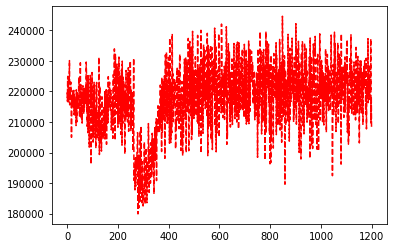

In [5]:
import matplotlib.pyplot as plt
plt.plot(cek1, cek2, 'r--')
plt.show()

In [6]:
# Q = np.loadtxt('Q.txt')
# Q

In [7]:
best_distance = 0
total_dis = []
for n in range(len(croute)):
    item_distance = 0
    item_route = croute[n]
    for i in range(len(item_route)):
        item_distance+=distance[item_route[i][0]][item_route[i][1]]
    total_dis.append(item_distance)    
        
for n in range(len(croute)):
    print("Rute "+str(n))
    print(str(croute[n])+" -> "+str(total_dis[n]))
    best_distance+=total_dis[n]
print("Total Distace : "+str(best_distance))
print(elapsed)

Rute 0
[[0, 24], [24, 23], [23, 29], [29, 46], [46, 42], [42, 26], [26, 0]] -> 26483.0
Rute 1
[[0, 7], [7, 25], [25, 3], [3, 17], [17, 28], [28, 20], [20, 27], [27, 0]] -> 23442.0
Rute 2
[[0, 43], [43, 34], [34, 13], [13, 39], [39, 12], [12, 31], [31, 0]] -> 22492.0
Rute 3
[[0, 48], [48, 41], [41, 21], [21, 38], [38, 19], [19, 0]] -> 27929.0
Rute 4
[[0, 44], [44, 36], [36, 4], [4, 32], [32, 10], [10, 22], [22, 0]] -> 20320.0
Rute 5
[[0, 30], [30, 50], [50, 14], [14, 2], [2, 6], [6, 0]] -> 21372.0
Rute 6
[[0, 11], [11, 9], [9, 45], [45, 33], [33, 35], [35, 0]] -> 27569.0
Rute 7
[[0, 40], [40, 49], [49, 37], [37, 8], [8, 18], [18, 1], [1, 0]] -> 16660.0
Rute 8
[[0, 15], [15, 5], [5, 47], [47, 16], [16, 0]] -> 21956.0
Total Distace : 208223.0
33.25652027130127


In [8]:
print(elapsed)

33.25652027130127
